In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from math import *

import scipy as sp
import scipy.optimize

from parser import read_data

In [3]:
from matplotlib.patches import Circle, Ellipse, Rectangle
from matplotlib.collections import PatchCollection

def circles(x, y, s, c='b', **kwargs):
    if np.isscalar(c):
        kwargs.setdefault('color', c)
        c = None
        
    patches = [Circle((x_, y_), s_) for x_, y_, s_ in np.broadcast(x, y, s)]
    collection = PatchCollection(patches, **kwargs)
    if c is not None:
        collection.set_array(np.asarray(c))
    ax = plt.gca()
    ax.add_collection(collection)
    ax.autoscale_view()
    plt.draw_if_interactive()
    if c is not None:
        plt.sci(collection)
    return collection

0.007563352584838867 to generate 500 particles with 100 obsticles
0.2648475170135498 to simulate 500 partitions with 100 obsticles


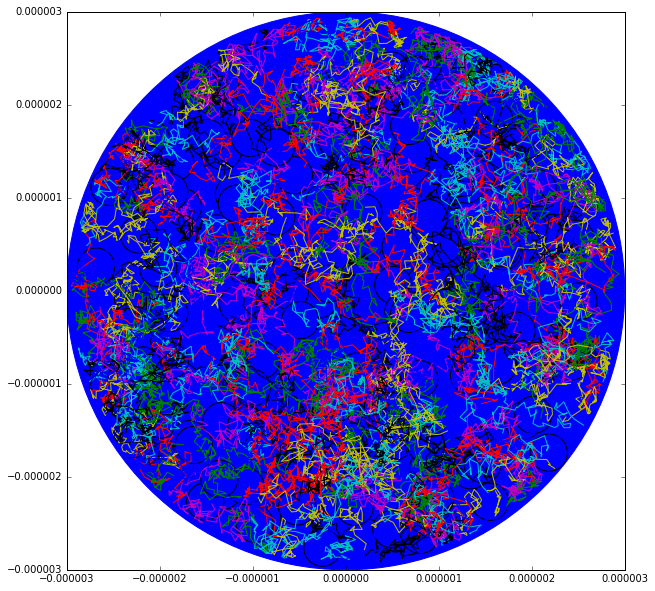

In [5]:
def plot_tracks(tracks, obsticles):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    ax.add_artist(plt.Circle((0, 0), R, color='b'))
    for obsticle in obsticles:
        ax.add_artist(plt.Circle(obsticle[:N-1], obsticle[N]))
    for (i, track) in enumerate(tracks):
        ax.plot(track[:, 0], track[:, 1])
    ax.autoscale()
    plt.savefig('./presentation/model.pdf')
    plt.show()
    

def to_xyz(array):
    alpha, r, h = array
    return np.array([array[1] * np.cos(array[0]), array[1] * np.sin(array[0]), h])


def generate_parametrization(size, min_r, max_r):
    if not size:
        return np.zeros((size, 4))
    
    rs = np.random.uniform(min_r, max_r, [size, 1])

    alphas = np.random.uniform(0, np.pi * 2, [size, 1])
    ps = (R - rs)**2 * np.random.uniform(0, 1, [size, 1])
    hs = np.random.uniform(rs, H - rs, [size, 1])
    
    return np.hstack([ps, alphas, hs, rs])


def parametrization_to_coords(values):
    ps = np.sqrt(values[:, 0:1])
    xs = ps * np.cos(values[:, 1:2])
    ys = ps * np.sin(values[:, 1:2])
    
    return np.hstack([xs, ys, values[:, 2:]])


def generate_points(size, min_r, max_r):
    return parametrization_to_coords(generate_parametrization(size, min_r, max_r))

def generate_particles(obsticles, part_cnt, min_r, max_r, min_prob=0):
    particles = generate_points(part_cnt, min_r, max_r)
    bad = filter_collisions(particles, obsticles)
    particles = particles[np.logical_not(bad)]
    prob = sum(np.logical_not(bad)) / len(bad)

    if prob < min_prob:
        print('ERROR! prob={} too low:'.format(prob))
        return None, None
    
    while particles.shape[0] < part_cnt:
        need = part_cnt - particles.shape[0]
        estimated = ceil(1.1 * need / prob)
        
        beings = generate_points(estimated, min_r, max_r)
        bad = filter_collisions(beings, obsticles)
        beings = beings[np.logical_not(bad)]
        particles = np.vstack([particles, beings[:need]])
    
    return particles, prob
        
def generate_particles_obsticles(part_cnt, min_r, max_r, obst_cnt, o_min_r, o_max_r, min_prob=0):
    obsticles = generate_points(obst_cnt, o_min_r, o_max_r)
    particles, _ = generate_particles(obsticles, part_cnt, min_r, max_r, min_prob)
    return particles, obsticles

def generate_displacement(particles, delta_t, pre_r):
    sigmas = np.sqrt(2 * pre_r / particles[:, N] * delta_t)
    return np.random.randn(particles.shape[0], particles.shape[1] - 1) * sigmas[:, np.newaxis]

def check_for_out_of_bounds(particles):
    first = particles[:, N] <= particles[:, N - 1]
    second = particles[:, N - 1] <= H - particles[:, N]
    third = np.linalg.norm(particles[:, :N - 1], axis=1) <= R - particles[:, N]
    
    return np.logical_not(np.logical_and(first, np.logical_and(second, third)))

def check_for_collisions_being(being, obsticles):
    return np.linalg.norm(obsticles[:, :N] - being[:N], axis=1) ** 2 < (obsticles[:, N] + being[N]) ** 2
    
def check_for_collisions_obsticle(obsticle, particles):
    return np.linalg.norm(particles[:, :N] - obsticle[:N], axis=1) ** 2 < (particles[:, N] + obsticle[N]) ** 2

def filter_collisions(particles, obsticles):
    if particles.shape[0] > obsticles.shape[0]:
        return np.any(np.apply_along_axis(check_for_collisions_obsticle, 1, obsticles, particles), axis=0)
    else:
        return np.any(np.apply_along_axis(check_for_collisions_being, 1, particles, obsticles), axis=1)

def build_tracks(particles, obsticles, length, pre_r):
    tracks = np.zeros([particles.shape[0], length, N])
    
    for i in range(length):
        tracks[:, i, :] = particles[:, :N]
    
        deltas = generate_displacement(particles, DELTA_T, pre_r)
        particles[:, :N] += deltas
        need_to_revert = np.logical_or(check_for_out_of_bounds(particles), filter_collisions(particles, obsticles))
        particles[:, :N][need_to_revert] -= deltas[need_to_revert]
        
    return tracks

def remove_same(track):
    indexes = np.hstack([[True], np.any(track[1:, :] != track[:-1, :], axis=1)]) 
    return track[indexes]

N = 3
ETA = 1.0e-5
kB = 1.38e-23
T = 293

PRE_R = kB * T / (3 * np.pi * ETA)

MIN_R = 0.5e2 * 1e-9
MAX_R = MIN_R#3e2 * 1e-9
O_MIN_R = 4 * MAX_R
O_MAX_R = 4 * MAX_R * 1
R = 10 * 1e-6 * 0.3
H = 1.5 * 1e-5 * 0.3


MAX_R_COEF = PRE_R / (2 * MIN_R)
# DELTA_T = R**2 / (2 * (N - 1) * MAX_R_COEF) / 3000
DELTA_T = 1.8 * 1e-6

PART_CNT = 1000 // 2
OBST_CNT = 100
TRACK_SIZE = 50


start_time = time.time()
particles, obsticles = generate_particles_obsticles(PART_CNT, MIN_R, MAX_R, OBST_CNT, O_MIN_R, O_MAX_R)
end_time = time.time()
print('{} to generate {} particles with {} obsticles'
      .format(end_time - start_time, len(particles), len(obsticles)))
start_time = time.time()
tracks = build_tracks(particles, obsticles, TRACK_SIZE, PRE_R)
end_time = time.time()
print('{} to simulate {} partitions with {} obsticles'
      .format(end_time - start_time, PART_CNT, OBST_CNT))

plot_tracks(tracks, obsticles)

[[  7.59902850e-01   9.36997804e-15]
 [  7.72527614e-01   4.17370658e-15]
 [  9.98571038e-01   2.32243200e-15]]
(2.3456522875277553e-07, 5.8851816740640988e-08, 0.75990285048648687, 9.3699780441561338e-15)
(4.5533895341386846e-07, 5.5080967993193539e-08, 0.77252761390658031, 4.173706584867945e-15)
(6.9413926473259157e-07, 1.2140068156746445e-07, 0.99857103773462874, 2.3224320044182776e-15)


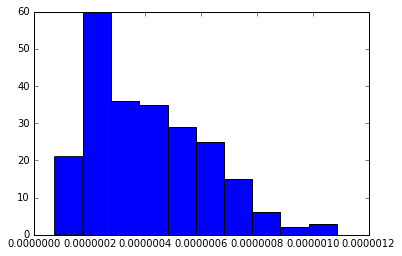

In [6]:
def low_data_std_values(coords, length_factor=1):
    xs = np.arange(1, int(coords.shape[0] * length_factor))
    ys = [np.mean([np.linalg.norm(coords[j + i, 1:] - coords[j, 1:])**2 for j in range(coords.shape[0] - i)]) for i in xs]
    return xs, ys

def large_data_std_values(tracks, length_factor=1):
    xs = np.arange(1, tracks[0].shape[0])
    ys = [np.mean(np.linalg.norm(tracks[:, i, :] - tracks[:, 0, :], axis=1)**2) for i in xs]
    return xs, ys

def t_function(x, alpha, beta):
    return beta * x**alpha

def std_to_curve_params(xs, ys, popt=[1, 1]):
    popt, _ = sp.optimize.curve_fit(t_function, xs, ys, popt)
    return popt

data = read_data()
plt.hist([np.mean(track[:, 0]) for track in data])

params = np.array([[np.mean(track[:, 0]), 
                    *std_to_curve_params(*low_data_std_values(track[:, 1:], 0.5))
                   ] for track in data])
sizes = [0, 7 * 0.05 * 1e-6, 11 * 0.05 * 1e-6, float('inf')]

r_means = []
r_stds = []
alphas = []
betas = []

for i in range(1, len(sizes)):
    indices = np.logical_and(sizes[i - 1] <= params[:, 0], params[:, 0] < sizes[i])
    
    r_means.append(np.mean(params[indices][:, 0]))
    r_stds.append(np.std(params[indices][:, 0]))
    alphas.append(np.mean(params[indices][:, 1]))
    betas.append(np.mean(params[indices][:, 2]))

target_vector = np.array(list(zip(alphas, betas)))
print(target_vector)
    
for i in zip(r_means, r_stds, alphas, betas):
    print(i)

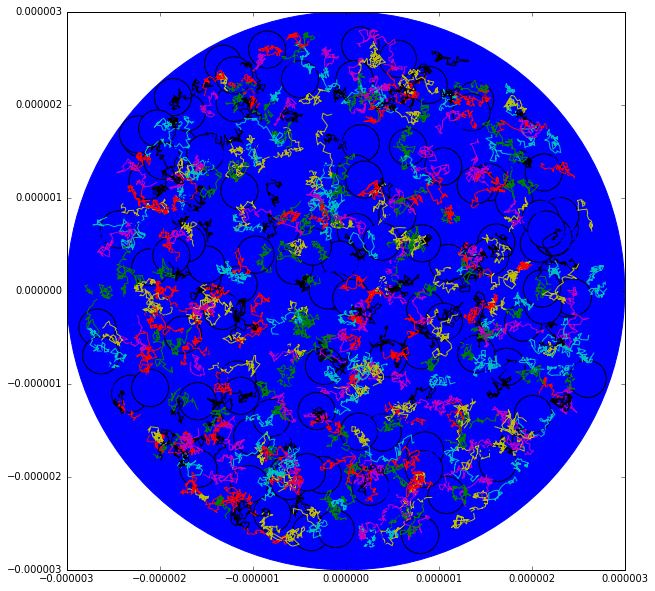

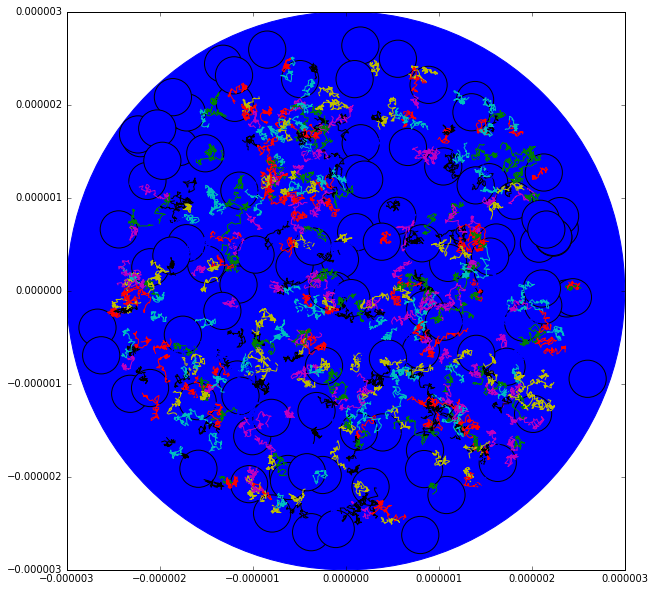

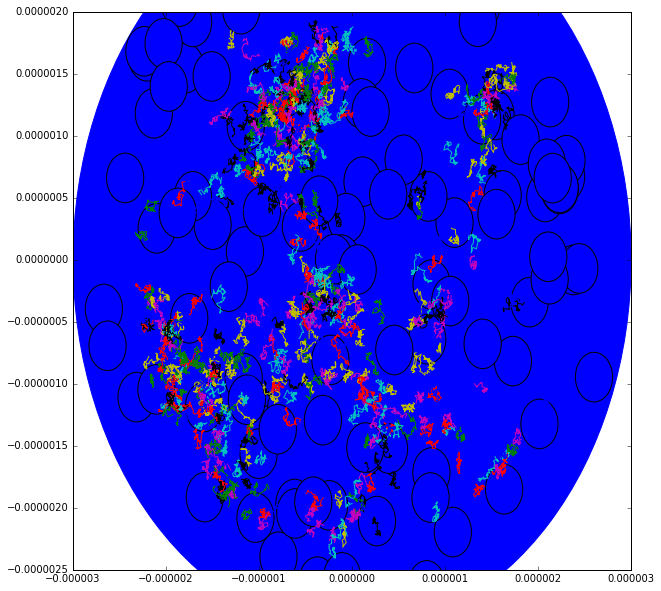

being: eta=1e-05, obst_cnt=100, min_obst_r=2.0000000000000002e-07, max_obst_r=2.0000000000000002e-07
result_params:
[[  9.48312783e-01   2.22678375e-15]
 [  9.44092988e-01   1.07804176e-15]
 [  9.49657847e-01   7.22266292e-16]]
fitness:
0.787010585673
0.787010585673


In [10]:
from operator import itemgetter


def calc_dist(t_vector, r_vector):
        return np.linalg.norm((t_vector - r_vector) / np.max(t_vector, axis=0))**2


def prob_penalty(prob):
    return 0 if prob > 0.15 else 1 if prob < 0.1 else 1 - (prob - 0.1) / (0.15 - 0.1)


def calculate_parameters(obsticles, pre_r, visualize=False):
    popts = []
    for r_mean, r_std in zip(r_means, r_stds):
        population, prob = generate_particles(obsticles, PART_CNT, r_mean - r_std, r_mean + r_std, 0.001)
        if population is None:
            return float('Inf')
        
        tracks = build_tracks(population, obsticles, TRACK_SIZE, pre_r)
        popts.append(std_to_curve_params(*large_data_std_values(tracks)))
        
        if visualize:
            plot_tracks(tracks, obsticles)
    
    return np.array(popts)


F_CNT = 5


def calculate_fitness(being, visualize=False, hard_visualize=False):
    eta = being[0]
    pre_r = kB * T / (3 * np.pi * eta)
    obst_cnt = being[1]
    obst_params = being[2:]
    
    result_params = calculate_parameters(generate_points(int(obst_cnt), *obst_params), pre_r)
    for i in range(F_CNT - 1):
        result_params += calculate_parameters(generate_points(int(obst_cnt), *obst_params), pre_r, 
                                              i == 0 and hard_visualize)
    result_params /= F_CNT
    
    result = calc_dist(target_vector, result_params)
    if visualize:
        print('being: eta={}, obst_cnt={}, min_obst_r={}, max_obst_r={}'.format(eta, obst_cnt, *obst_params))
        print('result_params:')
        print(result_params)
        print('fitness:')
        print(result)
    
    return result 

    
print(calculate_fitness([ETA, OBST_CNT, O_MIN_R, O_MAX_R], True, True))

In [13]:
being = [2.390041077895209e-06, 81.13152512255667, 2.288326199782245e-07, 1.9845026286264843e-07]
calculate_fitness(being, True)

being: eta=2.390041077895209e-06, obst_cnt=81.13152512255667, min_obst_r=2.288326199782245e-07, max_obst_r=1.9845026286264843e-07
result_params:
[[  9.65507326e-01   7.87754212e-15]
 [  9.06072764e-01   4.60383813e-15]
 [  8.81602062e-01   3.13170204e-15]]
fitness:
0.108937018847


0.10893701884673844

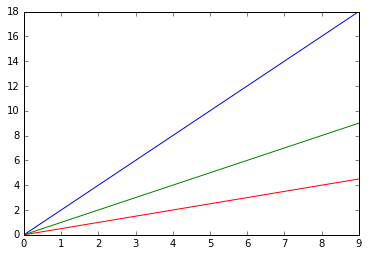

In [17]:
plt.plot(np.arange(10), np.arange(10) * 2)
plt.plot(np.arange(10), np.arange(10) * 1)
plt.plot(np.arange(10), np.arange(10) * 0.5)

In [18]:
F_CNT = 50 
PART_CNT = 50
ys = [calculate_fitness(being) for i in xs]

ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:


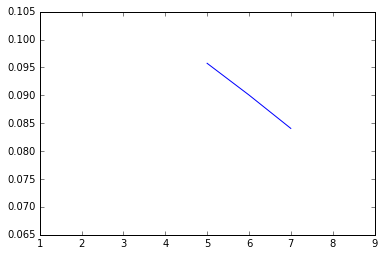

In [19]:
plt.plot(xs, ys)

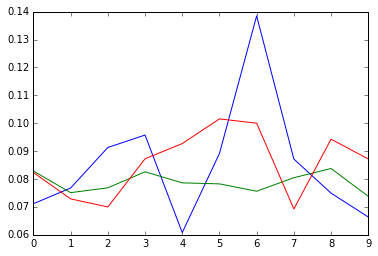

In [15]:
xs = np.arange(10)

F_CNT = 5
ys = [calculate_fitness(being) for i in xs]

plt.plot(xs, ys)

F_CNT = 50 
ys = [calculate_fitness(being) for i in xs]

plt.plot(xs, ys)

F_CNT = 5
PART_CNT = 1500
ys = [calculate_fitness(being) for i in xs]

plt.plot(xs, ys)

110
110
being: eta=2.4268935410456858e-06, obst_cnt=90.17042663649164, min_obst_r=2.3679787808146888e-07, max_obst_r=2.3307564983039422e-07
result_params:
[[  9.43455096e-01   8.37782411e-15]
 [  8.97658130e-01   4.66514893e-15]
 [  8.88536069e-01   2.93372441e-15]]
fitness:
0.0798517740247


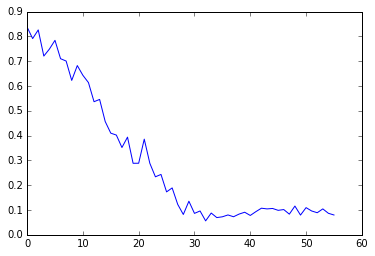

110
being: eta=2.5967105733346566e-06, obst_cnt=84.92118462840695, min_obst_r=2.837851431965813e-07, max_obst_r=2.1968802839116002e-07
result_params:
[[  9.16936446e-01   8.60208592e-15]
 [  9.21211138e-01   3.95524729e-15]
 [  8.77932358e-01   3.02554383e-15]]
fitness:
0.074386251368


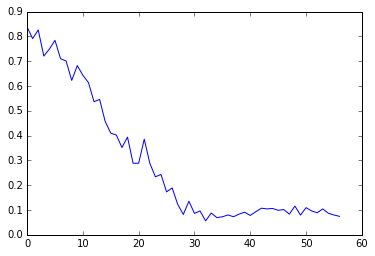

110
being: eta=2.470049607248949e-06, obst_cnt=95.6412805369113, min_obst_r=2.6111318139097515e-07, max_obst_r=2.1458610960886204e-07
result_params:
[[  9.43426475e-01   8.31957267e-15]
 [  8.96628636e-01   4.54105913e-15]
 [  8.98469230e-01   2.83897572e-15]]
fitness:
0.0764148747362


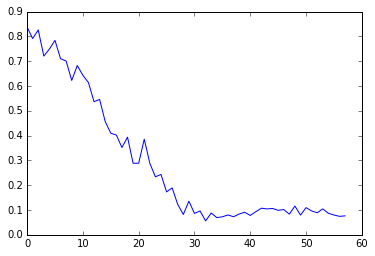

110
being: eta=2.5471746058526234e-06, obst_cnt=87.52241098204308, min_obst_r=2.7670380086762474e-07, max_obst_r=2.2489587036056169e-07
result_params:
[[  9.33013648e-01   8.02996674e-15]
 [  9.19314800e-01   3.99717937e-15]
 [  8.47135588e-01   3.26483616e-15]]
fitness:
0.105582591959


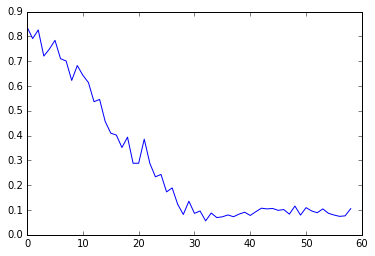

110
being: eta=2.4467418872034643e-06, obst_cnt=86.82213734082039, min_obst_r=2.867961500730054e-07, max_obst_r=2.2258440174012492e-07
result_params:
[[  9.48612959e-01   8.21348918e-15]
 [  8.88197996e-01   4.46473813e-15]
 [  8.63560476e-01   3.01671241e-15]]
fitness:
0.0891002071346


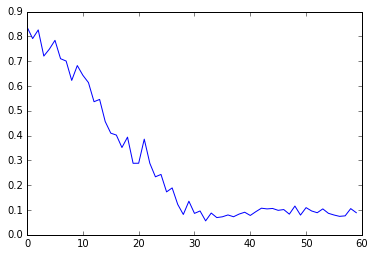

110
being: eta=2.446863597053635e-06, obst_cnt=103.25186762189868, min_obst_r=2.3645624196790718e-07, max_obst_r=2.3692435069368617e-07
result_params:
[[  9.52395613e-01   7.79582575e-15]
 [  8.94319835e-01   4.33363393e-15]
 [  8.67511472e-01   3.11951714e-15]]
fitness:
0.105012956415


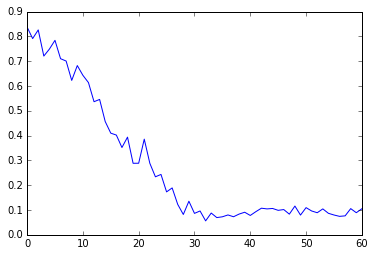

110
being: eta=2.4686733134706096e-06, obst_cnt=92.39059882834297, min_obst_r=2.5139286112758077e-07, max_obst_r=2.3020249576838695e-07
result_params:
[[  9.23562186e-01   8.44225305e-15]
 [  9.11751027e-01   4.02221500e-15]
 [  8.43700861e-01   3.12038285e-15]]
fitness:
0.0876699685396


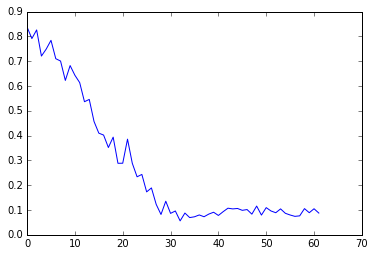

110
being: eta=2.287951232942992e-06, obst_cnt=86.51638110101645, min_obst_r=2.6449506251715623e-07, max_obst_r=2.398648498062064e-07
result_params:
[[  9.42690487e-01   8.42860522e-15]
 [  9.20232608e-01   4.43116566e-15]
 [  9.07327665e-01   3.11629654e-15]]
fitness:
0.0817622493279


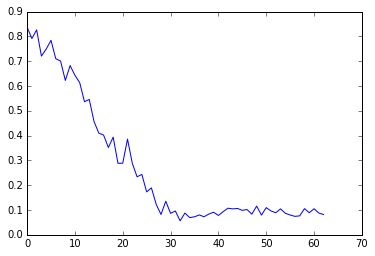

110
being: eta=2.4917382347257656e-06, obst_cnt=89.55481180438917, min_obst_r=2.7030489624316585e-07, max_obst_r=2.2557992940190003e-07
result_params:
[[  9.51591981e-01   7.95943034e-15]
 [  8.92522102e-01   4.48238287e-15]
 [  8.63886858e-01   3.00860492e-15]]
fitness:
0.0985916978227


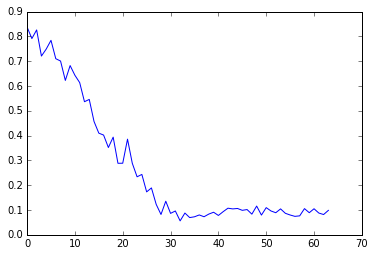

110
being: eta=2.574449147968233e-06, obst_cnt=96.18489096203207, min_obst_r=2.661769868819097e-07, max_obst_r=2.1811225798923161e-07
result_params:
[[  9.48263553e-01   7.73796173e-15]
 [  9.02506464e-01   4.15286609e-15]
 [  8.61810162e-01   2.96489588e-15]]
fitness:
0.106324581374


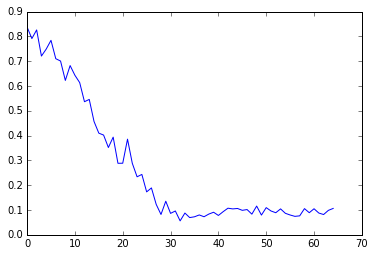

110
being: eta=2.408120855935933e-06, obst_cnt=87.88361651335909, min_obst_r=2.938729860849085e-07, max_obst_r=2.711101846072428e-07
result_params:
[[  9.35901115e-01   8.37889080e-15]
 [  8.81608736e-01   4.64708905e-15]
 [  8.75208479e-01   3.13068241e-15]]
fitness:
0.0794397380938


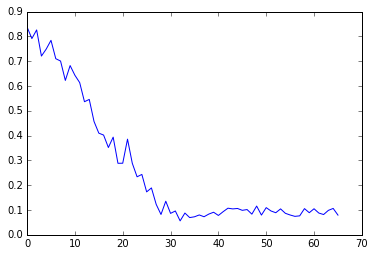

110
ERROR! prob=0.0 too low:
being: eta=2.5186713868895518e-06, obst_cnt=101.93565902987655, min_obst_r=2.921727270960083e-07, max_obst_r=2.9211932013119933e-07
result_params:
[[  9.00257581e-01   8.44967002e-15]
 [  8.92458316e-01   4.20743551e-15]
 [  8.59946003e-01   2.86980088e-15]]
fitness:
0.0665248502724


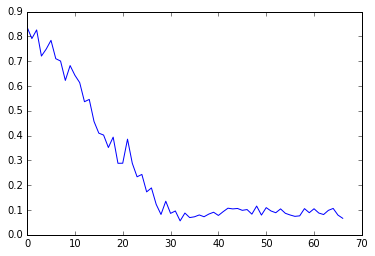

110
ERROR! prob=0.0 too low:
being: eta=2.584500486384166e-06, obst_cnt=104.00975371876274, min_obst_r=2.695578503062087e-07, max_obst_r=2.973053147689092e-07
result_params:
[[  9.18549947e-01   7.96330013e-15]
 [  9.02236039e-01   3.86679161e-15]
 [  8.22012830e-01   2.99097022e-15]]
fitness:
0.102076938167


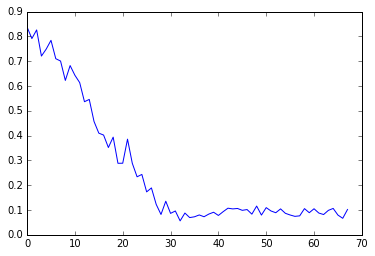

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.351580616858599e-06, obst_cnt=101.43958137573995, min_obst_r=2.626183873675701e-07, max_obst_r=2.7583144301316485e-07
result_params:
[[  9.47553377e-01   7.91019425e-15]
 [  9.09540439e-01   4.28366542e-15]
 [  8.45202643e-01   3.21201849e-15]]
fitness:
0.111152104023


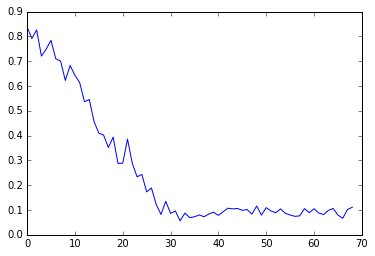

110
ERROR! prob=0.0 too low:
being: eta=2.3980992248802634e-06, obst_cnt=104.57880526780016, min_obst_r=2.7674359235071773e-07, max_obst_r=2.6571084162074094e-07
result_params:
[[  9.11315061e-01   8.63923247e-15]
 [  9.00034372e-01   4.18108991e-15]
 [  8.28212329e-01   3.37639248e-15]]
fitness:
0.0871361691682


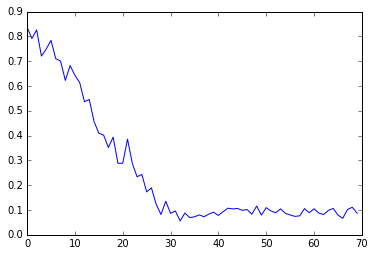

110
being: eta=2.437078512081828e-06, obst_cnt=101.64407454691897, min_obst_r=3.316684432742227e-07, max_obst_r=2.696129399708612e-07
result_params:
[[  9.17542820e-01   8.48484118e-15]
 [  8.84605483e-01   4.30356295e-15]
 [  8.13528602e-01   3.21425116e-15]]
fitness:
0.0900323893404


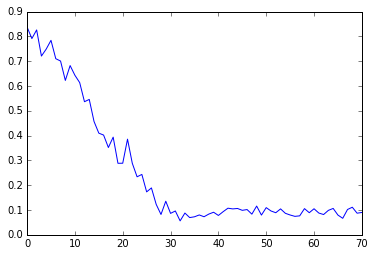

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.316283557058405e-06, obst_cnt=95.96018078735753, min_obst_r=3.2370044889979183e-07, max_obst_r=2.7010642471290107e-07
result_params:
[[  9.15610615e-01   8.82919013e-15]
 [  9.11301385e-01   4.14935738e-15]
 [  8.53422814e-01   3.13233475e-15]]
fitness:
0.0755649492709


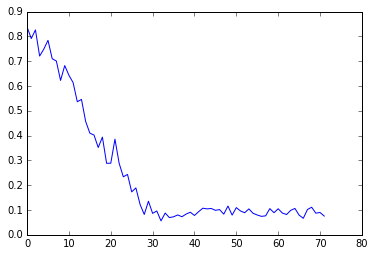

110
being: eta=2.3787348034036327e-06, obst_cnt=94.93743581423766, min_obst_r=2.923746958269882e-07, max_obst_r=2.76356846739816e-07
result_params:
[[  8.99321176e-01   9.50041266e-15]
 [  8.82081890e-01   4.47721684e-15]
 [  8.43712789e-01   3.25387576e-15]]
fitness:
0.0667042231022


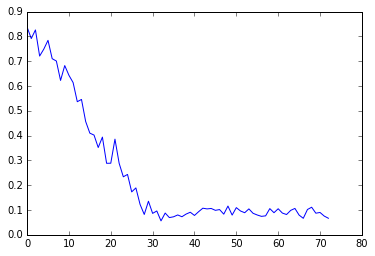

110
ERROR! prob=0.0 too low:
being: eta=2.280529665144475e-06, obst_cnt=105.07155856715002, min_obst_r=2.663462748069352e-07, max_obst_r=2.7859361770686774e-07
result_params:
[[  9.19918687e-01   9.10917307e-15]
 [  8.83715933e-01   4.74378947e-15]
 [  8.33601098e-01   3.42733126e-15]]
fitness:
0.0837510079791


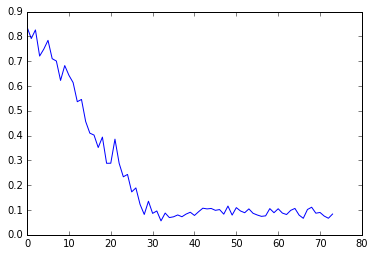

110
being: eta=2.3999205683999077e-06, obst_cnt=99.97455181976291, min_obst_r=3.1365957013510577e-07, max_obst_r=2.7211434640720316e-07
result_params:
[[  9.09823377e-01   8.61682674e-15]
 [  8.83651156e-01   4.42346221e-15]
 [  8.49100789e-01   2.98606834e-15]]
fitness:
0.06951728173


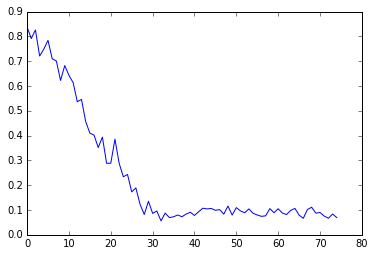

110
being: eta=2.411483818393104e-06, obst_cnt=94.5977603017521, min_obst_r=2.931374846759751e-07, max_obst_r=2.7501635790134227e-07
result_params:
[[  8.94450081e-01   9.20427902e-15]
 [  8.48716914e-01   4.87342606e-15]
 [  8.74073444e-01   2.94788089e-15]]
fitness:
0.0498652274537


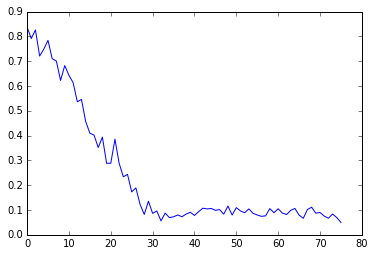

110
ERROR! prob=0.0 too low:
being: eta=2.459830283641955e-06, obst_cnt=96.37146931546587, min_obst_r=3.1632836341900387e-07, max_obst_r=2.8705275253217555e-07
result_params:
[[  9.32848799e-01   8.01293056e-15]
 [  8.75805150e-01   4.48244367e-15]
 [  8.97491652e-01   2.83035305e-15]]
fitness:
0.0759387048221


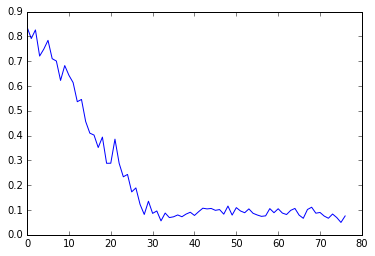

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.424882557694e-06, obst_cnt=92.67216193277288, min_obst_r=3.406283299994016e-07, max_obst_r=2.3454411809146806e-07
result_params:
[[  9.42575736e-01   8.05431765e-15]
 [  9.09441807e-01   4.10563332e-15]
 [  8.88292595e-01   2.79362170e-15]]
fitness:
0.0867575066383


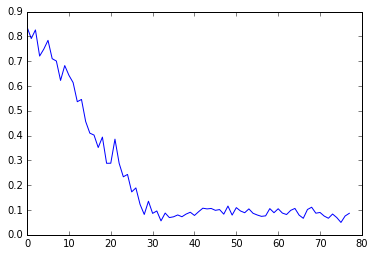

110
ERROR! prob=0.0 too low:
being: eta=2.3878433927686524e-06, obst_cnt=94.20406830316313, min_obst_r=3.2551212830339704e-07, max_obst_r=3.049484970803849e-07
result_params:
[[  9.17067964e-01   8.57549336e-15]
 [  8.58597934e-01   4.51415039e-15]
 [  8.31207526e-01   3.17742381e-15]]
fitness:
0.0771274442044


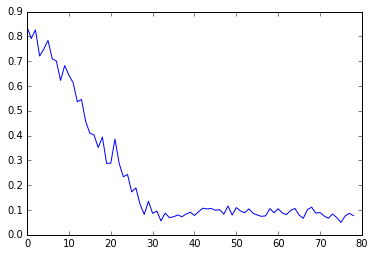

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.4048924572205277e-06, obst_cnt=95.70426185939553, min_obst_r=2.779329173289486e-07, max_obst_r=2.786581361910158e-07
result_params:
[[  9.28621526e-01   8.59721068e-15]
 [  8.86046108e-01   4.56748934e-15]
 [  8.74728337e-01   3.03990097e-15]]
fitness:
0.0712828717597


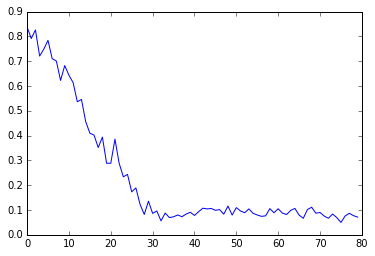

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.5247461576674473e-06, obst_cnt=96.56351386735604, min_obst_r=3.160552776003061e-07, max_obst_r=2.737304593477604e-07
result_params:
[[  9.40058339e-01   7.89418740e-15]
 [  8.99659573e-01   4.09357220e-15]
 [  8.61052659e-01   2.88609579e-15]]
fitness:
0.0962220704263


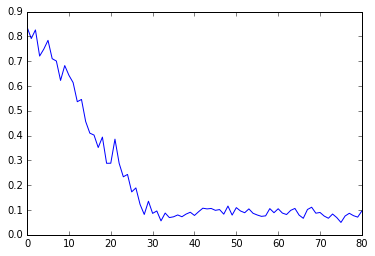

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.5683015447133687e-06, obst_cnt=95.38114505126849, min_obst_r=3.1588131102019823e-07, max_obst_r=2.4878267471809436e-07
result_params:
[[  9.37012428e-01   7.60572448e-15]
 [  8.81372374e-01   4.34226311e-15]
 [  8.45816524e-01   2.97408705e-15]]
fitness:
0.107352268873


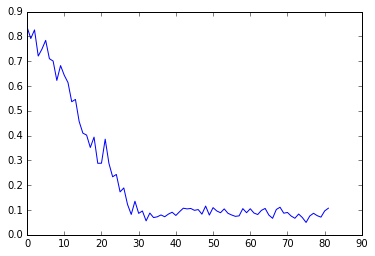

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.431966545272149e-06, obst_cnt=92.94796137214826, min_obst_r=3.4635876428690976e-07, max_obst_r=2.9689352216418984e-07
result_params:
[[  9.27860586e-01   8.02087784e-15]
 [  8.60252732e-01   4.58389293e-15]
 [  8.19494022e-01   3.14976567e-15]]
fitness:
0.0986119469821


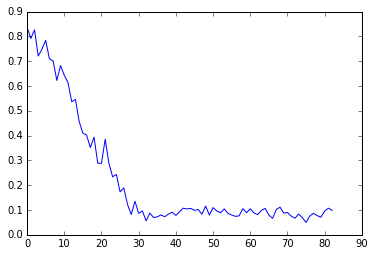

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.3439906950958555e-06, obst_cnt=87.89679828614983, min_obst_r=3.5057958440184877e-07, max_obst_r=2.692831846983223e-07
result_params:
[[  9.49758153e-01   8.10953841e-15]
 [  8.87465072e-01   4.65214611e-15]
 [  8.41155799e-01   3.25357267e-15]]
fitness:
0.104825189884


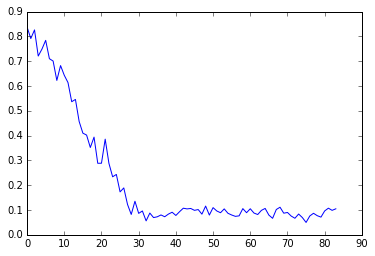

110
ERROR! prob=0.0 too low:
being: eta=2.366993761524404e-06, obst_cnt=92.20521747395193, min_obst_r=3.474906746805043e-07, max_obst_r=2.9905413853480935e-07
result_params:
[[  9.37971018e-01   7.94065915e-15]
 [  8.72647566e-01   4.46723515e-15]
 [  8.20837859e-01   3.14265786e-15]]
fitness:
0.105444728532


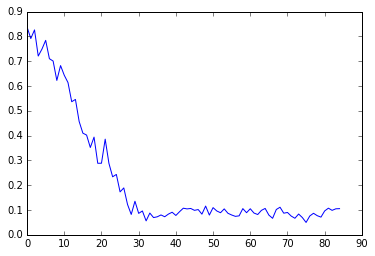

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.3789471056160563e-06, obst_cnt=87.56836916504207, min_obst_r=3.626420319932305e-07, max_obst_r=3.1322810519922386e-07
result_params:
[[  9.18355776e-01   8.53247132e-15]
 [  8.88743548e-01   4.31384469e-15]
 [  8.48659404e-01   3.11508088e-15]]
fitness:
0.0766309756496


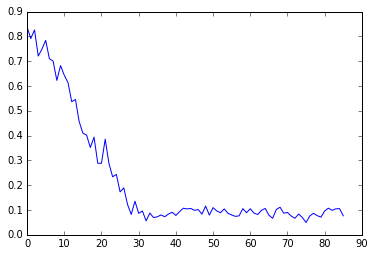

110
being: eta=2.399326244201216e-06, obst_cnt=89.97690650945991, min_obst_r=3.1685340403801865e-07, max_obst_r=2.760199220451614e-07
result_params:
[[  9.35139420e-01   8.16296522e-15]
 [  9.25621031e-01   4.04000134e-15]
 [  8.62558601e-01   3.09337744e-15]]
fitness:
0.0964200522478


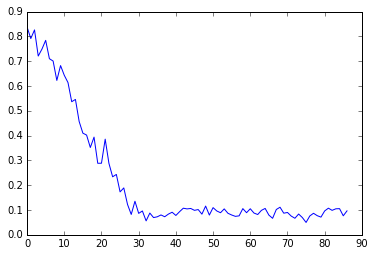

110
ERROR! prob=0.0 too low:
being: eta=2.294620264168055e-06, obst_cnt=86.62645223347367, min_obst_r=3.7794880456688693e-07, max_obst_r=3.0195633368657296e-07
result_params:
[[  8.93340625e-01   9.80946596e-15]
 [  8.75614344e-01   4.75579975e-15]
 [  8.22688262e-01   3.58166726e-15]]
fitness:
0.0836573440109


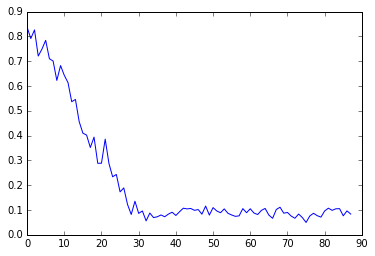

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.6484551934391143e-06, obst_cnt=94.41784729527846, min_obst_r=3.375842606043888e-07, max_obst_r=3.1224632653576234e-07
result_params:
[[  9.20009286e-01   7.97870212e-15]
 [  8.95166552e-01   3.99713128e-15]
 [  8.44316666e-01   3.02264126e-15]]
fitness:
0.0926399804709


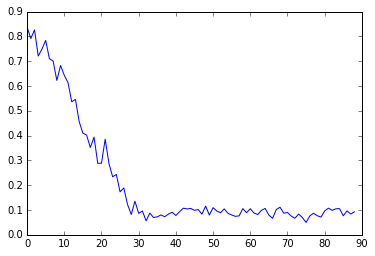

110
ERROR! prob=0.0 too low:
being: eta=2.5065061435333233e-06, obst_cnt=91.51145186277266, min_obst_r=3.3662429083669184e-07, max_obst_r=2.9432964177693963e-07
result_params:
[[  9.06290125e-01   8.50289940e-15]
 [  8.95763169e-01   4.04887589e-15]
 [  8.57769261e-01   2.78938135e-15]]
fitness:
0.0678272785578


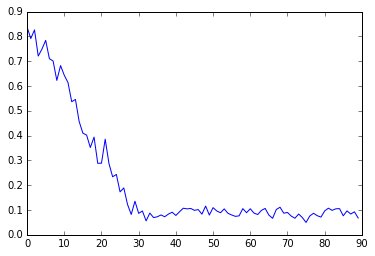

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.4577103163527807e-06, obst_cnt=90.54589539744414, min_obst_r=3.6659701070679745e-07, max_obst_r=3.640194447634667e-07
result_params:
[[ inf  inf]
 [ inf  inf]
 [ inf  inf]]
fitness:
inf


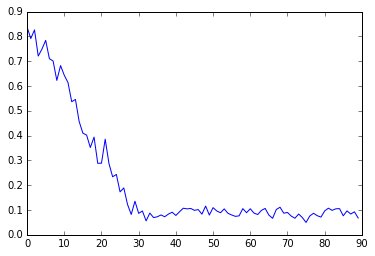

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.5579707497618168e-06, obst_cnt=88.54341289357562, min_obst_r=3.279021587634675e-07, max_obst_r=3.584001163808706e-07
result_params:
[[  9.36223710e-01   7.45258644e-15]
 [  9.00685845e-01   4.06304216e-15]
 [  8.49467268e-01   2.83527129e-15]]
fitness:
0.114954371636


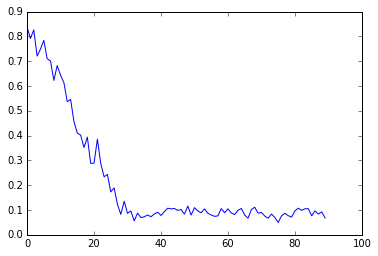

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.4954038562400744e-06, obst_cnt=95.22063546560716, min_obst_r=3.4382295256714656e-07, max_obst_r=2.9685356678617096e-07
result_params:
[[  9.04922511e-01   8.54357847e-15]
 [  8.90255922e-01   4.06016930e-15]
 [  8.18442203e-01   3.10551683e-15]]
fitness:
0.0824399471237


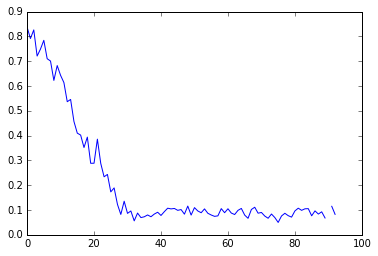

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.4300946310869394e-06, obst_cnt=81.76249556133023, min_obst_r=3.9521098685988596e-07, max_obst_r=3.182420817989855e-07
result_params:
[[  9.33946620e-01   8.29094260e-15]
 [  8.79869135e-01   4.25593838e-15]
 [  8.73850116e-01   2.94088038e-15]]
fitness:
0.0752280412456


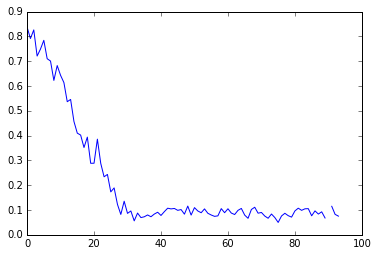

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.458611741314509e-06, obst_cnt=82.01451659235472, min_obst_r=3.3566355775451325e-07, max_obst_r=3.107495725965204e-07
result_params:
[[  8.91288690e-01   9.25017518e-15]
 [  8.91388887e-01   4.25390672e-15]
 [  8.64932307e-01   2.84455814e-15]]
fitness:
0.0527324301349


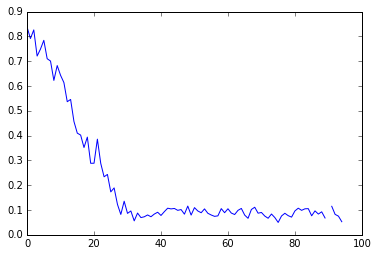

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.449849082379588e-06, obst_cnt=81.68852748679942, min_obst_r=3.754904171711142e-07, max_obst_r=3.1702711175636895e-07
result_params:
[[  9.38290489e-01   7.82821539e-15]
 [  8.87794146e-01   4.51131948e-15]
 [  8.82506312e-01   2.88493856e-15]]
fitness:
0.0907238618196


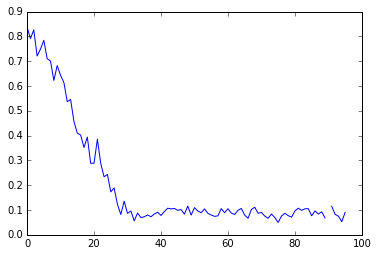

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.4531890972715793e-06, obst_cnt=81.17022992169782, min_obst_r=3.802633792615918e-07, max_obst_r=3.0501562933856144e-07
result_params:
[[  9.28470190e-01   7.94482176e-15]
 [  8.75342315e-01   4.48986258e-15]
 [  8.44083536e-01   3.11493229e-15]]
fitness:
0.0944580894754


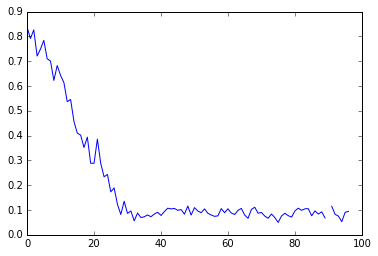

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.4123145113084254e-06, obst_cnt=85.63946119537674, min_obst_r=3.5675277712395097e-07, max_obst_r=3.151012369609263e-07
result_params:
[[  9.17659012e-01   8.61569713e-15]
 [  9.03083451e-01   4.04415589e-15]
 [  8.38393180e-01   3.01108469e-15]]
fitness:
0.0798553416495


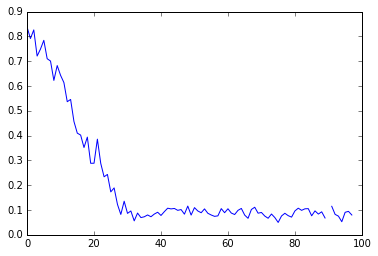

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.51804474621236e-06, obst_cnt=84.392351723091, min_obst_r=3.7032054996800585e-07, max_obst_r=3.0119420319830885e-07
result_params:
[[  9.41116532e-01   7.46261747e-15]
 [  9.07745574e-01   4.10602609e-15]
 [  8.26209115e-01   2.99458528e-15]]
fitness:
0.127697498255


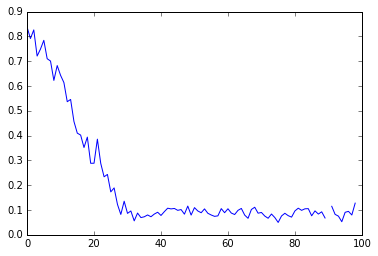

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.382058248035745e-06, obst_cnt=86.18678061111345, min_obst_r=3.2286014366989973e-07, max_obst_r=3.232505244885642e-07
result_params:
[[  9.06933717e-01   9.09763100e-15]
 [  8.66549131e-01   4.69987772e-15]
 [  8.38113403e-01   3.09732420e-15]]
fitness:
0.0672031617465


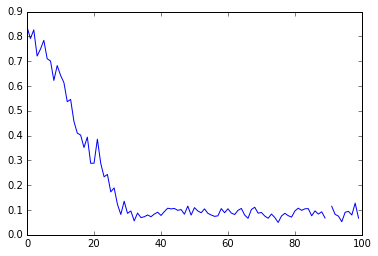

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.449126870823456e-06, obst_cnt=89.80858400429925, min_obst_r=3.5245752877401775e-07, max_obst_r=3.0197994610903016e-07
result_params:
[[  8.96365210e-01   8.70061796e-15]
 [  9.08519285e-01   4.17162975e-15]
 [  8.57423053e-01   3.00546698e-15]]
fitness:
0.0676189166619


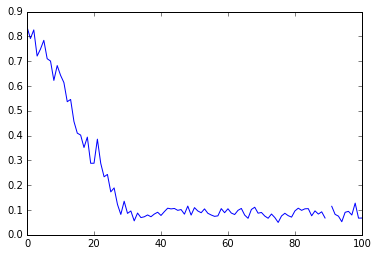

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.449126870823456e-06, obst_cnt=89.80858400429925, min_obst_r=3.5245752877401775e-07, max_obst_r=3.0197994610903016e-07
result_params:
[[  9.08823967e-01   8.62907025e-15]
 [  9.05759886e-01   4.06172090e-15]
 [  8.45326768e-01   3.11028527e-15]]
fitness:
0.0770589669872


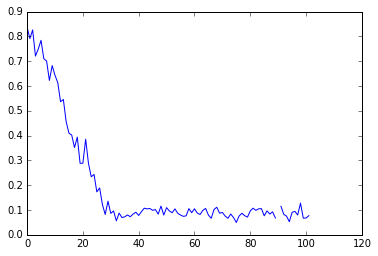

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.475866029519709e-06, obst_cnt=87.71075250856127, min_obst_r=3.2610581775918533e-07, max_obst_r=3.4425528588130664e-07
result_params:
[[  9.37072809e-01   7.75476995e-15]
 [  8.87930819e-01   4.26479919e-15]
 [  8.55929287e-01   3.01455639e-15]]
fitness:
0.100506084077


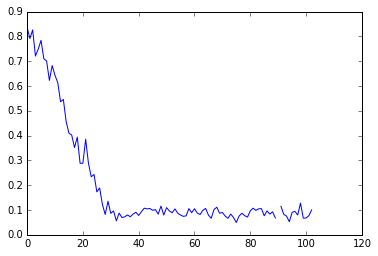

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.2563308518138056e-06, obst_cnt=85.85889804773713, min_obst_r=3.804561597132075e-07, max_obst_r=3.286740281494494e-07
result_params:
[[  9.59269035e-01   7.86275722e-15]
 [  8.71408705e-01   4.76180634e-15]
 [  8.13373280e-01   3.59467206e-15]]
fitness:
0.132312515823


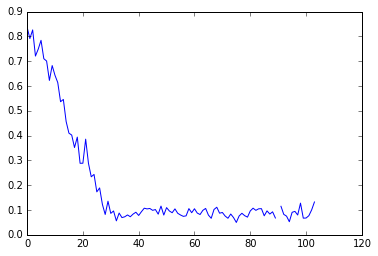

110
ERROR! prob=0.0 too low:
being: eta=2.3750087091057053e-06, obst_cnt=87.2024906114653, min_obst_r=3.135961660082768e-07, max_obst_r=3.2015139138501706e-07
result_params:
[[  9.19313270e-01   8.62800335e-15]
 [  8.34304192e-01   5.28385136e-15]
 [  8.38234721e-01   3.25698281e-15]]
fitness:
0.0853486745345


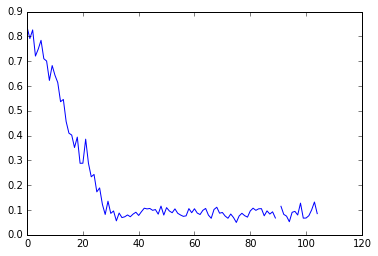

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.5632116081025e-06, obst_cnt=85.2019313365169, min_obst_r=3.4374618370834307e-07, max_obst_r=3.0561832825440754e-07
result_params:
[[  9.25934725e-01   7.79339932e-15]
 [  8.86533216e-01   4.28574514e-15]
 [  8.47120476e-01   2.98441729e-15]]
fitness:
0.0971282788453


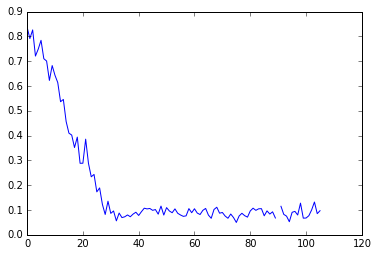

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.3739294781260544e-06, obst_cnt=87.19763484462187, min_obst_r=3.936294163670407e-07, max_obst_r=3.0686309890432673e-07
result_params:
[[  9.17349559e-01   8.52237738e-15]
 [  8.98732044e-01   4.29308639e-15]
 [  8.71851938e-01   2.94322953e-15]]
fitness:
0.0696721296293


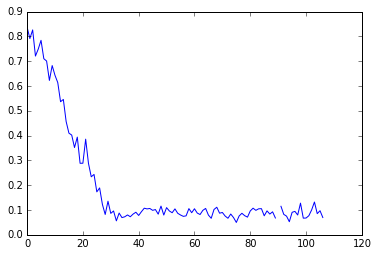

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.3757046854393678e-06, obst_cnt=85.08067311591141, min_obst_r=3.748366695038388e-07, max_obst_r=3.271198595026512e-07
result_params:
[[  8.98935503e-01   9.24578466e-15]
 [  8.65900326e-01   4.63893659e-15]
 [  8.39440741e-01   3.18471540e-15]]
fitness:
0.0646335846809


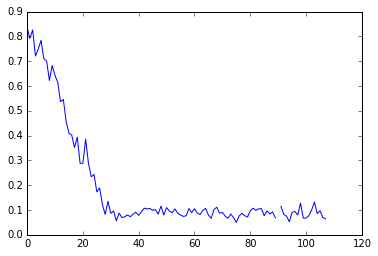

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.3638516340936704e-06, obst_cnt=74.67087190780337, min_obst_r=3.7109180920869544e-07, max_obst_r=3.050540227061855e-07
result_params:
[[  9.23710433e-01   8.43192721e-15]
 [  9.04562898e-01   4.34682250e-15]
 [  8.28078803e-01   3.55504510e-15]]
fitness:
0.101212903727


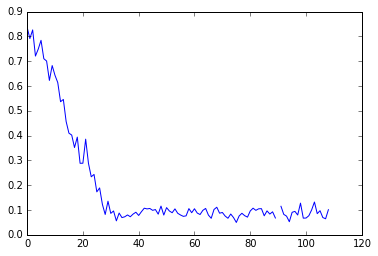

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.5812276138929557e-06, obst_cnt=86.07097589262398, min_obst_r=3.5596908278017683e-07, max_obst_r=3.1065645970799807e-07
result_params:
[[  9.24000332e-01   7.93633885e-15]
 [  8.52139064e-01   4.48532839e-15]
 [  8.42777486e-01   2.94459562e-15]]
fitness:
0.0866274295178


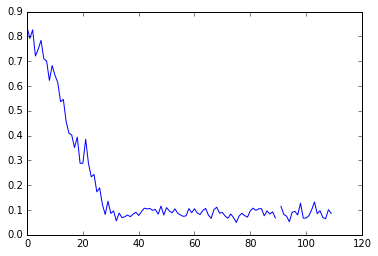

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.2898181463183434e-06, obst_cnt=76.63640329097566, min_obst_r=3.919301141170954e-07, max_obst_r=3.4676875167640954e-07
result_params:
[[ inf  inf]
 [ inf  inf]
 [ inf  inf]]
fitness:
inf


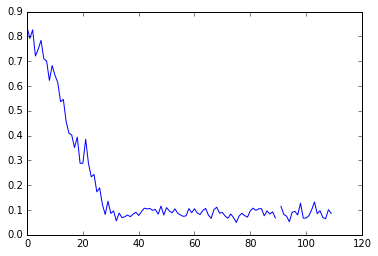

110
ERROR! prob=0.0 too low:
being: eta=2.388931543010165e-06, obst_cnt=78.53146437767897, min_obst_r=3.90386140894168e-07, max_obst_r=3.370558929853283e-07
result_params:
[[  9.12320418e-01   8.60785893e-15]
 [  8.57918973e-01   4.78168647e-15]
 [  8.37709444e-01   3.24973399e-15]]
fitness:
0.0771806737032


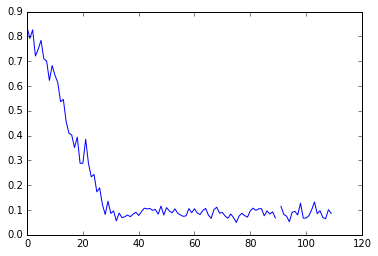

110
being: eta=2.34925502060673e-06, obst_cnt=78.69617169268602, min_obst_r=3.8300485688639384e-07, max_obst_r=3.0208328192651736e-07
result_params:
[[  9.38249106e-01   8.35030183e-15]
 [  9.13652354e-01   4.35370467e-15]
 [  8.54450869e-01   3.08411093e-15]]
fitness:
0.09152141704


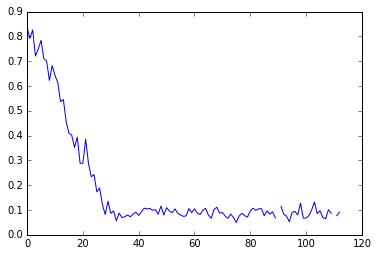

110
ERROR! prob=0.0 too low:
being: eta=2.5684901087627724e-06, obst_cnt=91.17778032712336, min_obst_r=3.5676403906627854e-07, max_obst_r=3.0280775336842423e-07
result_params:
[[  8.90604462e-01   8.57653378e-15]
 [  8.77553871e-01   4.33378955e-15]
 [  8.31630349e-01   3.10018360e-15]]
fitness:
0.07049521564


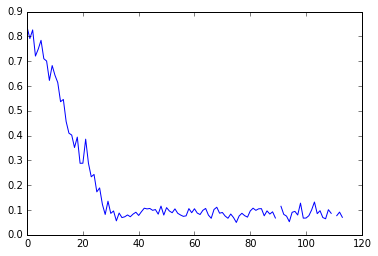

110
ERROR! prob=0.0 too low:
being: eta=2.382320556172974e-06, obst_cnt=77.79367736896201, min_obst_r=3.61910094591074e-07, max_obst_r=2.868720113987899e-07
result_params:
[[  9.49977736e-01   7.87427272e-15]
 [  8.90057680e-01   4.55361764e-15]
 [  8.48747219e-01   3.22491127e-15]]
fitness:
0.10899791623


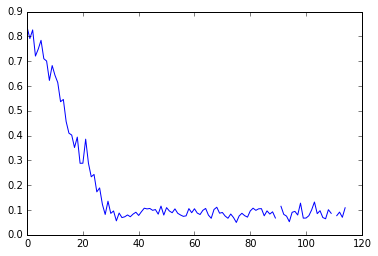

110
being: eta=2.46153791246115e-06, obst_cnt=75.78490154814007, min_obst_r=3.9625738092556116e-07, max_obst_r=3.687266051122395e-07
result_params:
[[  9.27850272e-01   8.05692943e-15]
 [  8.90282226e-01   4.26689533e-15]
 [  8.64925735e-01   2.98541546e-15]]
fitness:
0.0848479704713


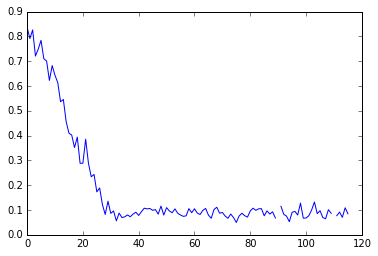

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.3928344336005075e-06, obst_cnt=75.14705742266369, min_obst_r=3.6032923952340383e-07, max_obst_r=2.898420062779893e-07
result_params:
[[  9.03241257e-01   9.04559248e-15]
 [  8.88337613e-01   4.73388361e-15]
 [  8.63028629e-01   3.10794157e-15]]
fitness:
0.0642800551333


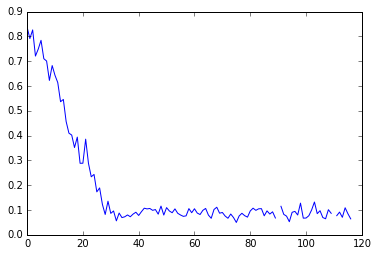

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.446991775904216e-06, obst_cnt=81.08242605032946, min_obst_r=3.4076207147682506e-07, max_obst_r=3.158679967390837e-07
result_params:
[[  9.05424537e-01   8.92202577e-15]
 [  8.82837560e-01   4.25239659e-15]
 [  8.42663868e-01   3.01473285e-15]]
fitness:
0.0656320582006


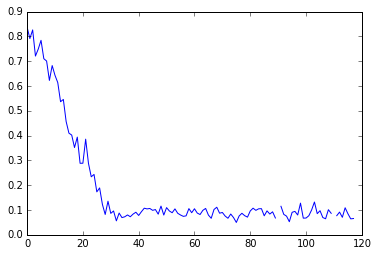

110
ERROR! prob=0.0 too low:
being: eta=2.543649276182843e-06, obst_cnt=77.57735822303587, min_obst_r=4.030677756331224e-07, max_obst_r=2.9993288786980077e-07
result_params:
[[  9.21313042e-01   8.27741740e-15]
 [  8.83992710e-01   4.30569713e-15]
 [  8.21415654e-01   3.30439136e-15]]
fitness:
0.0948390733268


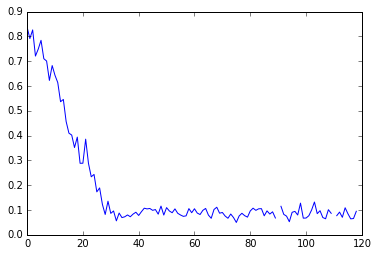

110
ERROR! prob=0.0 too low:
being: eta=2.431018554443007e-06, obst_cnt=78.14944161860413, min_obst_r=3.678135059163173e-07, max_obst_r=2.965871217346002e-07
result_params:
[[  9.33730616e-01   8.18829077e-15]
 [  9.22799638e-01   4.01694501e-15]
 [  8.75579215e-01   2.94316605e-15]]
fitness:
0.0886926739945


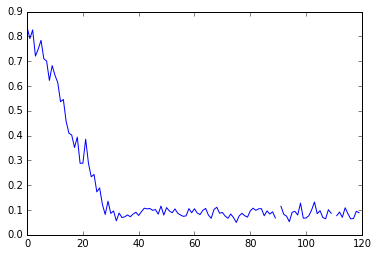

110
ERROR! prob=0.0 too low:
being: eta=2.5492890200556415e-06, obst_cnt=78.31935010568574, min_obst_r=3.7255349042733897e-07, max_obst_r=3.017694543611775e-07
result_params:
[[  9.35645700e-01   7.54015806e-15]
 [  9.03022806e-01   3.95306821e-15]
 [  8.15087435e-01   3.18648045e-15]]
fitness:
0.12900882425


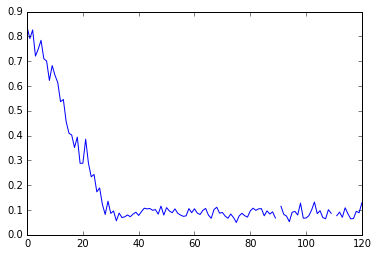

110
being: eta=2.503857323868957e-06, obst_cnt=70.1309963996173, min_obst_r=3.621938477715517e-07, max_obst_r=3.1555092282469986e-07
result_params:
[[  9.35621868e-01   8.03080468e-15]
 [  9.08272108e-01   4.09484726e-15]
 [  8.66408102e-01   3.00779714e-15]]
fitness:
0.0928096291102


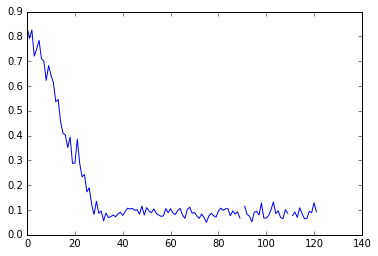

110
being: eta=2.4464130497406835e-06, obst_cnt=75.96973907663362, min_obst_r=3.296683654213351e-07, max_obst_r=3.581947963071472e-07
result_params:
[[  9.20256820e-01   8.46149023e-15]
 [  8.97299909e-01   4.32999575e-15]
 [  8.87413038e-01   2.91166572e-15]]
fitness:
0.0674247363721


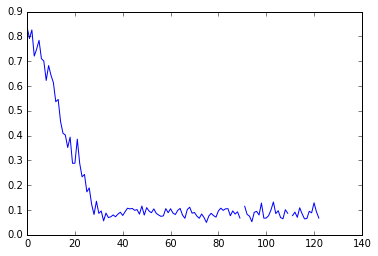

110
being: eta=2.357553234896754e-06, obst_cnt=80.06348647792252, min_obst_r=3.775256733770959e-07, max_obst_r=3.322678964766193e-07
result_params:
[[  9.01018636e-01   9.03317131e-15]
 [  8.93421265e-01   4.37375134e-15]
 [  8.08725155e-01   3.43068537e-15]]
fitness:
0.0865098457567


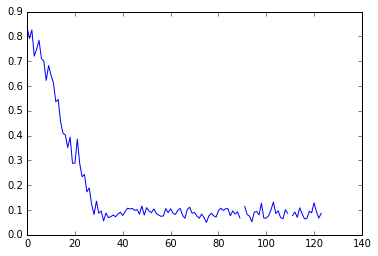

110
being: eta=2.351912362736121e-06, obst_cnt=80.44750056352382, min_obst_r=3.358894494102002e-07, max_obst_r=2.9849947544319944e-07
result_params:
[[  9.47263826e-01   8.14762977e-15]
 [  8.90435386e-01   4.69028197e-15]
 [  8.83584645e-01   2.98070611e-15]]
fitness:
0.0873996172808


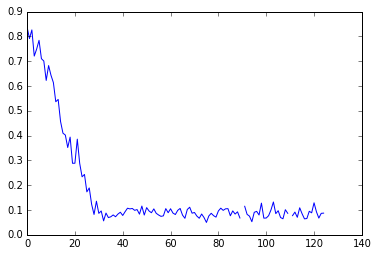

110
ERROR! prob=0.0 too low:
being: eta=2.4053008164918107e-06, obst_cnt=81.57090205463888, min_obst_r=3.2042355448013447e-07, max_obst_r=3.6363968648145826e-07
result_params:
[[  9.20685949e-01   8.42673163e-15]
 [  8.89126393e-01   4.20434921e-15]
 [  8.60061122e-01   2.86263113e-15]]
fitness:
0.0722676830087


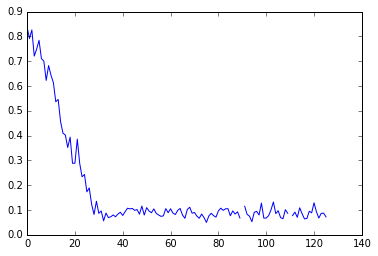

110
being: eta=2.495924361527771e-06, obst_cnt=81.93455758949408, min_obst_r=3.339440754776559e-07, max_obst_r=3.6901603257093796e-07
result_params:
[[  9.14291707e-01   8.58798425e-15]
 [  8.83419677e-01   4.37148297e-15]
 [  8.37720147e-01   3.15828914e-15]]
fitness:
0.0775519140962


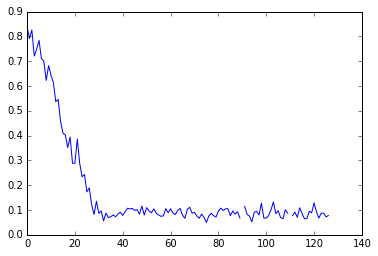

110
ERROR! prob=0.0 too low:
being: eta=2.4808043141509004e-06, obst_cnt=80.23681653773814, min_obst_r=3.5765995634553755e-07, max_obst_r=3.9388177185996523e-07
result_params:
[[  9.03902981e-01   8.27362821e-15]
 [  8.67781602e-01   4.39124174e-15]
 [  8.08766264e-01   3.29075892e-15]]
fitness:
0.0909332098636


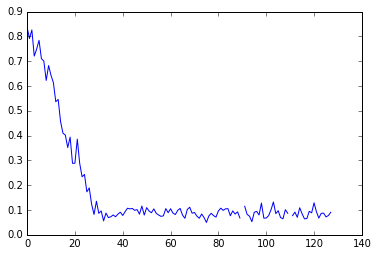

110
ERROR! prob=0.0 too low:
being: eta=2.3631552708295974e-06, obst_cnt=76.25877779855692, min_obst_r=3.7417615884829505e-07, max_obst_r=3.1754283821057593e-07
result_params:
[[  9.18026196e-01   8.41705559e-15]
 [  9.17301158e-01   3.99401789e-15]
 [  8.43714663e-01   3.14448228e-15]]
fitness:
0.0885507119152


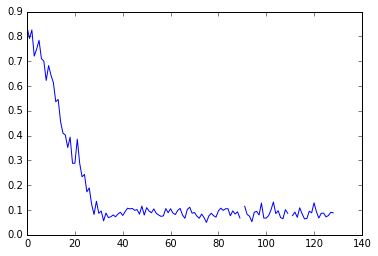

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.364338608237408e-06, obst_cnt=78.61286254607545, min_obst_r=3.596185480171253e-07, max_obst_r=3.1422955618549927e-07
result_params:
[[  9.01449482e-01   9.27750609e-15]
 [  8.88449093e-01   4.53781749e-15]
 [  8.60534627e-01   3.04929569e-15]]
fitness:
0.0603028487399


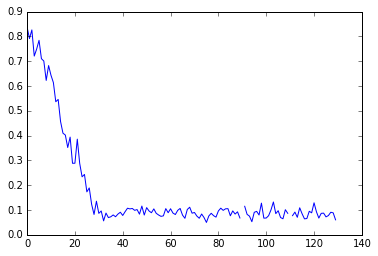

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.4163660510129275e-06, obst_cnt=72.44103756107977, min_obst_r=3.5835059477772465e-07, max_obst_r=3.442184239532537e-07
result_params:
[[  9.20519187e-01   8.57079377e-15]
 [  8.81965641e-01   4.64011051e-15]
 [  8.38585028e-01   3.42457706e-15]]
fitness:
0.0871394020636


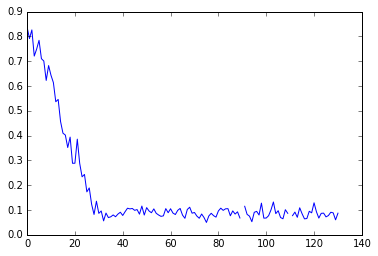

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.5227344983196342e-06, obst_cnt=80.42482916525678, min_obst_r=4.267620131367411e-07, max_obst_r=3.263551011852956e-07
result_params:
[[  9.07801743e-01   8.21985138e-15]
 [  8.68178051e-01   4.36877547e-15]
 [  8.70498325e-01   2.71477284e-15]]
fitness:
0.0648147862862


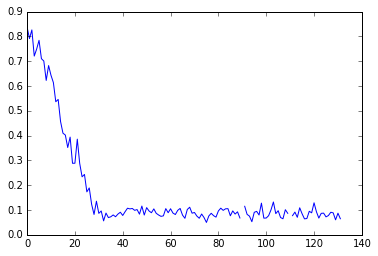

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.387218298813561e-06, obst_cnt=81.38197819274568, min_obst_r=4.1339690807618356e-07, max_obst_r=3.4329389036577845e-07
result_params:
[[  9.12107819e-01   8.39290758e-15]
 [  8.62928292e-01   4.85163697e-15]
 [  8.56037592e-01   3.01934231e-15]]
fitness:
0.0734426360624


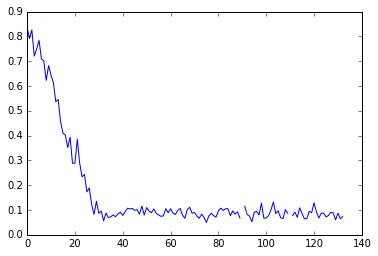

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.337533648238872e-06, obst_cnt=70.13486526656114, min_obst_r=3.650112045632291e-07, max_obst_r=4.116378212976444e-07
result_params:
[[  9.27342281e-01   8.19559577e-15]
 [  8.76194013e-01   4.81273067e-15]
 [  8.37122238e-01   3.39335561e-15]]
fitness:
0.0984569119726


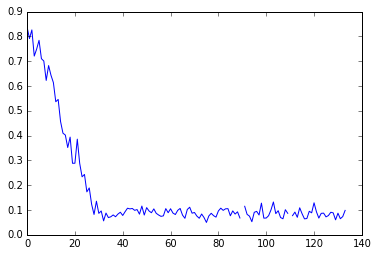

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.558583909543386e-06, obst_cnt=82.64677443835475, min_obst_r=3.866019288863405e-07, max_obst_r=3.3524831785722733e-07
result_params:
[[  9.19478739e-01   7.87261582e-15]
 [  8.81590493e-01   4.06646368e-15]
 [  8.29841868e-01   3.02337101e-15]]
fitness:
0.0972817098708


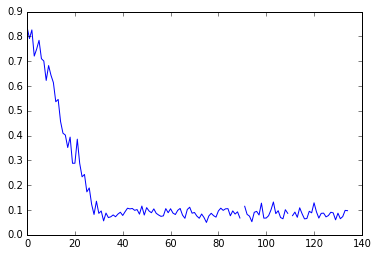

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.3816938133920377e-06, obst_cnt=79.44198272218233, min_obst_r=4.1664115530629094e-07, max_obst_r=2.881219598155998e-07
result_params:
[[  9.13679987e-01   8.73984083e-15]
 [  8.53745776e-01   4.95200137e-15]
 [  8.11446309e-01   3.39191378e-15]]
fitness:
0.0898961730863


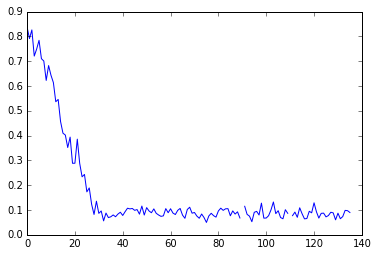

110
ERROR! prob=0.0 too low:
being: eta=2.364363990449713e-06, obst_cnt=80.9922586544343, min_obst_r=3.93089211419863e-07, max_obst_r=3.269682936312945e-07
result_params:
[[  9.07132666e-01   8.98098187e-15]
 [  8.75133635e-01   4.73649614e-15]
 [  8.79905269e-01   2.99740878e-15]]
fitness:
0.0569390267218


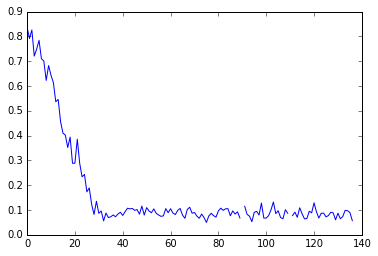

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.4193914529528854e-06, obst_cnt=80.51303114387986, min_obst_r=3.959617457129608e-07, max_obst_r=3.290666387084208e-07
result_params:
[[  9.22591692e-01   8.17741230e-15]
 [  8.93833986e-01   4.30561644e-15]
 [  8.43125342e-01   3.15639616e-15]]
fitness:
0.0898522633279


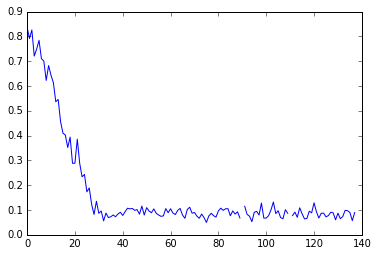

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.4872651111135973e-06, obst_cnt=85.43018775042724, min_obst_r=4.1645689854618144e-07, max_obst_r=3.31971412841352e-07
result_params:
[[  9.02506370e-01   8.14025367e-15]
 [  8.81343698e-01   4.10029661e-15]
 [  8.14017932e-01   3.04006584e-15]]
fitness:
0.0895776329495


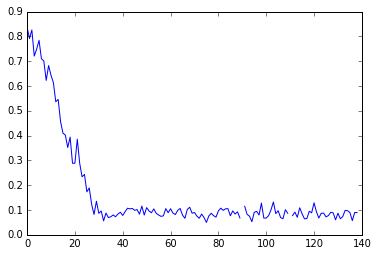

110
being: eta=2.6251152923797885e-06, obst_cnt=79.63710389753385, min_obst_r=3.9995805412146614e-07, max_obst_r=3.3491178507836176e-07
result_params:
[[  9.22622958e-01   7.48493549e-15]
 [  8.77936771e-01   4.25124530e-15]
 [  8.61116139e-01   2.75912479e-15]]
fitness:
0.0993580771163


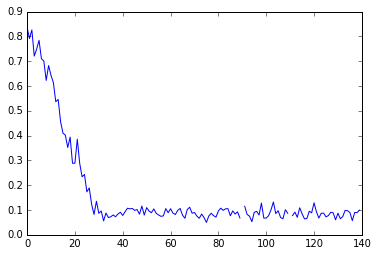

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.4672999874722113e-06, obst_cnt=77.95273400123777, min_obst_r=3.9064755715521884e-07, max_obst_r=3.2697292031445704e-07
result_params:
[[  8.96350230e-01   9.01913203e-15]
 [  8.82094159e-01   4.43372007e-15]
 [  8.52562800e-01   2.99333626e-15]]
fitness:
0.0593887225164


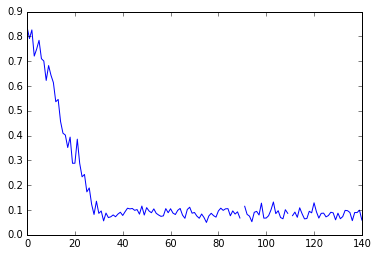

110
being: eta=2.3333023345787636e-06, obst_cnt=78.14513824397386, min_obst_r=3.9587089804181514e-07, max_obst_r=3.241300377934377e-07
result_params:
[[  8.85065258e-01   9.52739992e-15]
 [  9.10825181e-01   4.16737987e-15]
 [  8.72478930e-01   2.98513619e-15]]
fitness:
0.0561211799392


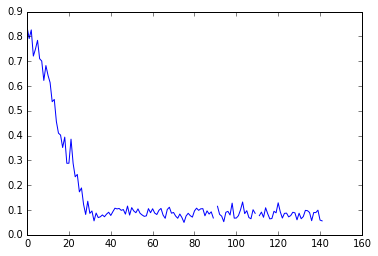

110
being: eta=2.4561871951747197e-06, obst_cnt=79.84051650774559, min_obst_r=3.8995582082061755e-07, max_obst_r=3.147924428189449e-07
result_params:
[[  9.23376619e-01   8.11238453e-15]
 [  8.88132147e-01   4.24670166e-15]
 [  8.15315274e-01   3.22562497e-15]]
fitness:
0.101247623124


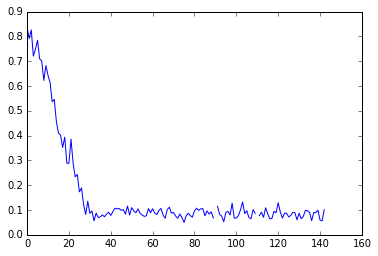

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.48068656461419e-06, obst_cnt=66.57267480112195, min_obst_r=3.882346795410851e-07, max_obst_r=3.235977254772998e-07
result_params:
[[  9.09322510e-01   8.83416517e-15]
 [  9.07966204e-01   4.21857014e-15]
 [  8.73834318e-01   2.91871159e-15]]
fitness:
0.0637327735793


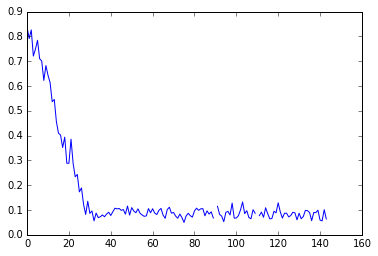

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.4932455934213153e-06, obst_cnt=66.68141214650231, min_obst_r=3.5881310229477874e-07, max_obst_r=3.346703824715286e-07
result_params:
[[  9.41553364e-01   7.95565020e-15]
 [  9.02215142e-01   4.31689784e-15]
 [  9.05607683e-01   2.66649416e-15]]
fitness:
0.0829908814663


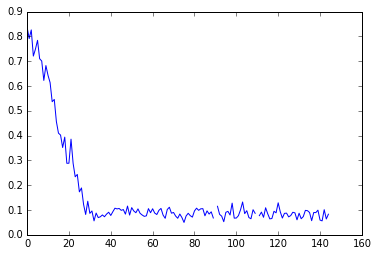

110
being: eta=2.5483825838166105e-06, obst_cnt=63.947520697125775, min_obst_r=3.515981331596913e-07, max_obst_r=3.311818125806916e-07
result_params:
[[  9.46187401e-01   7.80954474e-15]
 [  8.92868442e-01   4.38091593e-15]
 [  8.85068578e-01   2.79620816e-15]]
fitness:
0.0930241435166


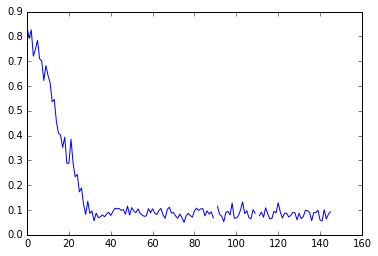

110
being: eta=2.636766530505467e-06, obst_cnt=59.98042732141992, min_obst_r=4.233024097049611e-07, max_obst_r=3.224107041447101e-07
result_params:
[[  9.16664470e-01   8.38771060e-15]
 [  9.15423552e-01   4.00833734e-15]
 [  8.64938350e-01   2.90672857e-15]]
fitness:
0.0782208189115


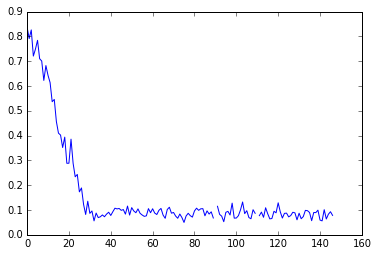

110
being: eta=2.4292383409145183e-06, obst_cnt=62.78891672323945, min_obst_r=4.396712736897065e-07, max_obst_r=3.442470160113274e-07
result_params:
[[  8.89688767e-01   9.49553351e-15]
 [  9.04025849e-01   4.30762084e-15]
 [  8.62332911e-01   3.06501814e-15]]
fitness:
0.0595125578118


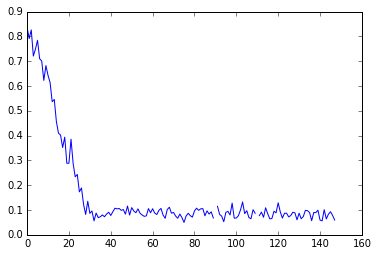

110
being: eta=2.456366718538998e-06, obst_cnt=60.838418828910015, min_obst_r=3.4622390228799e-07, max_obst_r=3.28571691992765e-07
result_params:
[[  9.32170379e-01   8.55758408e-15]
 [  9.17320367e-01   4.19940637e-15]
 [  9.01397462e-01   2.89855552e-15]]
fitness:
0.0715610968343


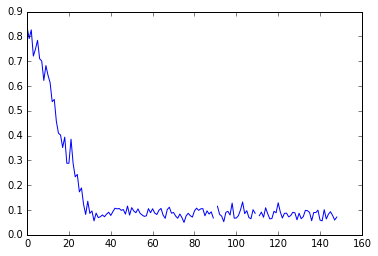

110
being: eta=2.5638120725693977e-06, obst_cnt=63.84211344694439, min_obst_r=3.618592560295821e-07, max_obst_r=3.355826473154752e-07
result_params:
[[  9.36727473e-01   7.63815695e-15]
 [  9.01677697e-01   4.06800183e-15]
 [  8.48786052e-01   3.02425153e-15]]
fitness:
0.110482086787


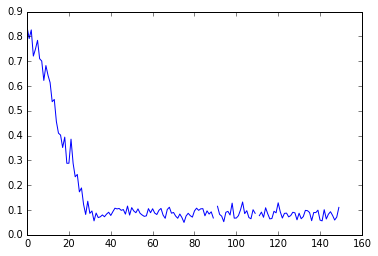

110
being: eta=2.5213955869382796e-06, obst_cnt=69.47374430110753, min_obst_r=3.597161314141079e-07, max_obst_r=3.465611087793448e-07
result_params:
[[  9.26024223e-01   8.11258485e-15]
 [  9.05623183e-01   4.15425158e-15]
 [  8.80067249e-01   3.00789239e-15]]
fitness:
0.0828878243645


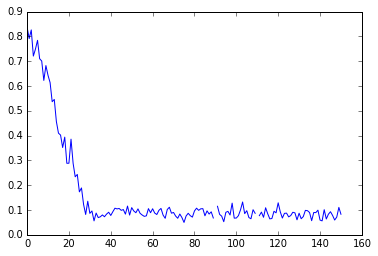

110
being: eta=2.3694135964059404e-06, obst_cnt=61.28463250249514, min_obst_r=3.611104526147112e-07, max_obst_r=2.936093855551084e-07
result_params:
[[  9.33054029e-01   9.05762214e-15]
 [  9.08608910e-01   4.58296663e-15]
 [  8.77535712e-01   3.21871569e-15]]
fitness:
0.0754987367406


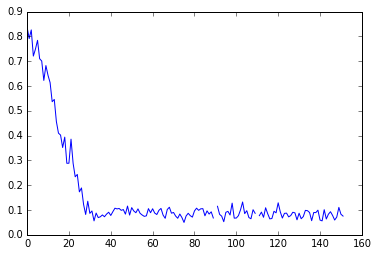

110
ERROR! prob=0.0 too low:
being: eta=2.291136884262018e-06, obst_cnt=65.54865696872625, min_obst_r=3.7784556380863155e-07, max_obst_r=3.3169573578414014e-07
result_params:
[[  9.53426471e-01   8.13217045e-15]
 [  8.89183457e-01   4.68112314e-15]
 [  8.69149262e-01   3.05401869e-15]]
fitness:
0.0944842679409


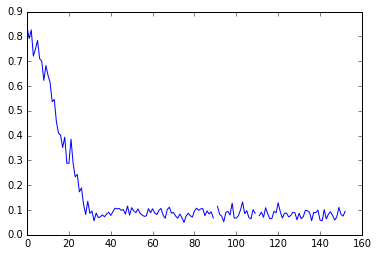

110
being: eta=2.433718088058224e-06, obst_cnt=62.703242137266095, min_obst_r=3.782288297455634e-07, max_obst_r=3.640707639574272e-07
result_params:
[[  9.30701965e-01   8.36379787e-15]
 [  8.94184907e-01   4.36976181e-15]
 [  8.71255883e-01   2.98509097e-15]]
fitness:
0.0773248797102


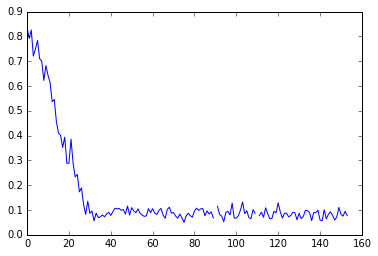

110
being: eta=2.39595528709001e-06, obst_cnt=61.40276494626263, min_obst_r=4.092890877250933e-07, max_obst_r=3.5643359544890304e-07
result_params:
[[  9.30107974e-01   8.42255822e-15]
 [  8.74236558e-01   4.82751243e-15]
 [  8.52024207e-01   3.28479944e-15]]
fitness:
0.0866058903456


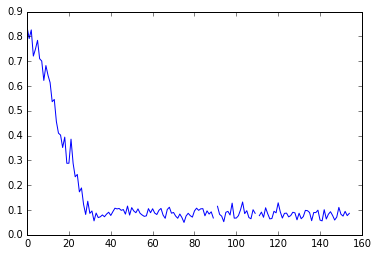

110
ERROR! prob=0.0 too low:
being: eta=2.413807487206849e-06, obst_cnt=65.43546200246543, min_obst_r=3.891501256986115e-07, max_obst_r=3.663964518069455e-07
result_params:
[[  8.96962955e-01   9.34463233e-15]
 [  8.94774404e-01   4.40296638e-15]
 [  8.66765254e-01   2.93254185e-15]]
fitness:
0.0560945872099


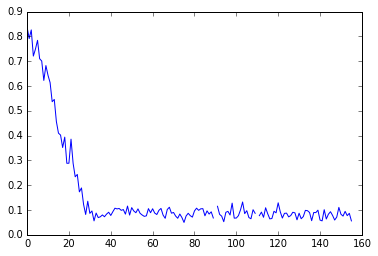

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.4380235240253966e-06, obst_cnt=61.93064835142809, min_obst_r=4.1448260850130515e-07, max_obst_r=3.6000121346084103e-07
result_params:
[[  9.39156325e-01   7.96450445e-15]
 [  8.95760141e-01   4.50517605e-15]
 [  8.84322099e-01   2.98433847e-15]]
fitness:
0.0892846681513


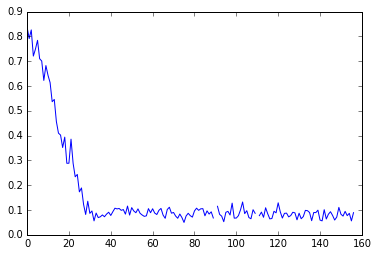

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.4380235240253966e-06, obst_cnt=61.93064835142809, min_obst_r=4.1448260850130515e-07, max_obst_r=3.6000121346084103e-07
result_params:
[[  9.17539734e-01   8.48675128e-15]
 [  9.36563749e-01   3.73576276e-15]
 [  8.20331971e-01   3.28516850e-15]]
fitness:
0.105392302625


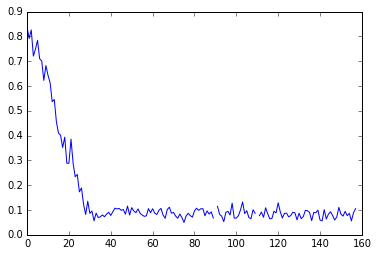

110
being: eta=2.3714958150182157e-06, obst_cnt=60.84775376993254, min_obst_r=4.0576383824655795e-07, max_obst_r=3.513047510315594e-07
result_params:
[[  9.00059282e-01   9.55341629e-15]
 [  8.98819673e-01   4.50708167e-15]
 [  8.97258133e-01   2.96893514e-15]]
fitness:
0.0523989187988


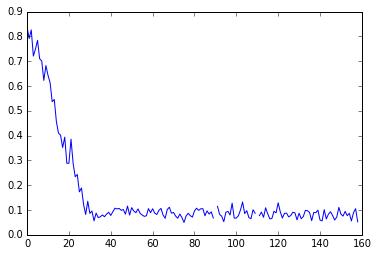

110
being: eta=2.427560124878417e-06, obst_cnt=66.66723856580657, min_obst_r=3.861123960398676e-07, max_obst_r=3.308407851043215e-07
result_params:
[[  9.12702813e-01   8.68960959e-15]
 [  8.97209433e-01   4.47450288e-15]
 [  8.71232395e-01   3.04649885e-15]]
fitness:
0.067540785565


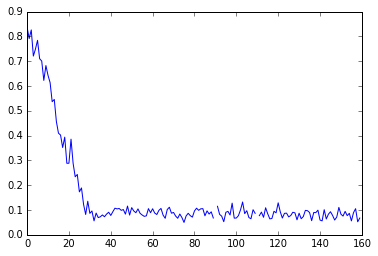

110
being: eta=2.4763828594227345e-06, obst_cnt=68.1543937384497, min_obst_r=4.15139334884768e-07, max_obst_r=3.4203888027899055e-07
result_params:
[[  9.25170383e-01   8.33121696e-15]
 [  9.09206377e-01   4.10661203e-15]
 [  8.74830360e-01   2.90642460e-15]]
fitness:
0.0777076425865


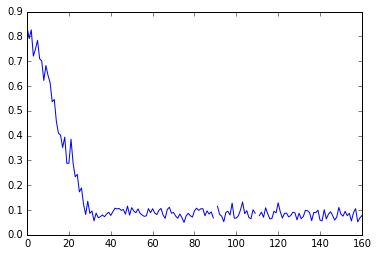

110
being: eta=2.546312518237686e-06, obst_cnt=68.38905428106452, min_obst_r=4.378662866184453e-07, max_obst_r=3.189864754594133e-07
result_params:
[[  9.25170231e-01   8.07800410e-15]
 [  8.78034485e-01   4.55388197e-15]
 [  8.90592632e-01   2.80890022e-15]]
fitness:
0.07360164152


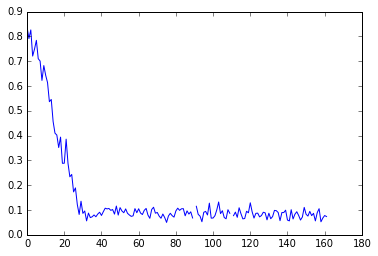

110
being: eta=2.545846603531598e-06, obst_cnt=68.35133288223383, min_obst_r=3.9166531495184857e-07, max_obst_r=3.467935825013618e-07
result_params:
[[  9.07788263e-01   8.53141704e-15]
 [  9.16986894e-01   3.87591628e-15]
 [  9.14365995e-01   2.51186814e-15]]
fitness:
0.0593998315275


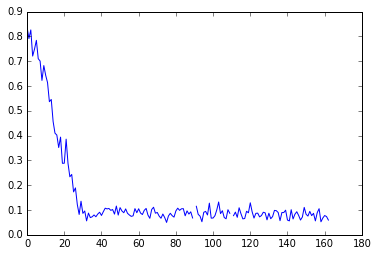

110
being: eta=2.50360360249138e-06, obst_cnt=66.86806534192893, min_obst_r=4.3439614879583163e-07, max_obst_r=3.510834681352468e-07
result_params:
[[  9.28587145e-01   8.07161693e-15]
 [  8.75530626e-01   4.48734780e-15]
 [  8.46143164e-01   3.25372212e-15]]
fitness:
0.0926762357708


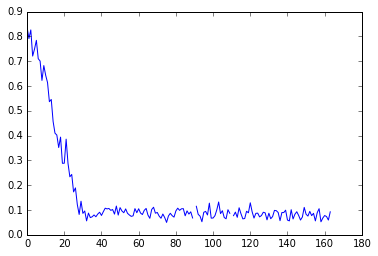

110
being: eta=2.4854339931923484e-06, obst_cnt=68.62280071006319, min_obst_r=3.998890969364534e-07, max_obst_r=3.383373433016015e-07
result_params:
[[  9.29619248e-01   8.06352853e-15]
 [  8.81397703e-01   4.58507747e-15]
 [  8.77517593e-01   2.84830020e-15]]
fitness:
0.0799864657339


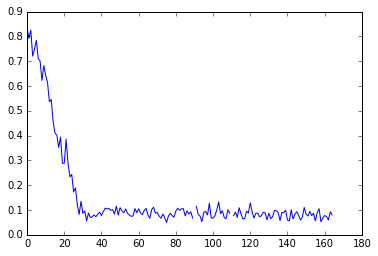

110
being: eta=2.3810449975226056e-06, obst_cnt=63.720503870590726, min_obst_r=3.582760569533886e-07, max_obst_r=3.633000573298762e-07
result_params:
[[  9.10825878e-01   9.08737523e-15]
 [  8.97249942e-01   4.36728730e-15]
 [  8.64637412e-01   3.13645491e-15]]
fitness:
0.0653166545248


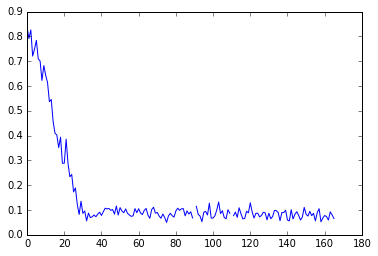

110
being: eta=2.3860570919524536e-06, obst_cnt=61.66192676151517, min_obst_r=3.3761872232542455e-07, max_obst_r=3.2757058341765015e-07
result_params:
[[  9.22219038e-01   8.79931543e-15]
 [  9.18064347e-01   4.39071165e-15]
 [  8.57070876e-01   3.32766199e-15]]
fitness:
0.0834982552653


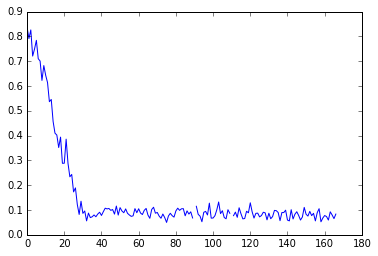

110
being: eta=2.3314769913270798e-06, obst_cnt=67.59441895959698, min_obst_r=4.4445538600357876e-07, max_obst_r=3.2914073580297973e-07
result_params:
[[  9.31176316e-01   8.49499356e-15]
 [  8.89158207e-01   4.57657816e-15]
 [  8.25330590e-01   3.47657601e-15]]
fitness:
0.098899278762


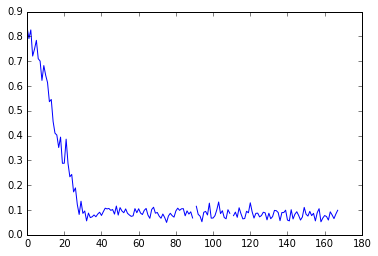

110
ERROR! prob=0.0 too low:
ERROR! prob=0.0 too low:
being: eta=2.473218063285588e-06, obst_cnt=59.96626021438808, min_obst_r=3.4318321153397675e-07, max_obst_r=3.3425409779679193e-07
result_params:
[[  9.47679327e-01   7.79450957e-15]
 [  9.15064598e-01   4.24787018e-15]
 [  8.71342273e-01   3.15072593e-15]]
fitness:
0.108117543424


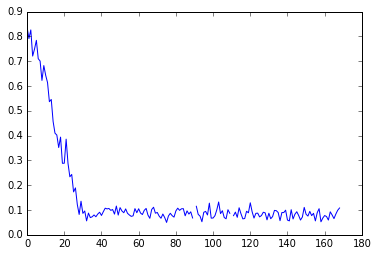

110
being: eta=2.483247633148304e-06, obst_cnt=65.46757055695072, min_obst_r=3.2624815534191356e-07, max_obst_r=3.3723413708143055e-07
result_params:
[[  9.13185902e-01   8.68370373e-15]
 [  9.32943422e-01   3.91765479e-15]
 [  8.67529795e-01   3.14240188e-15]]
fitness:
0.0803600875295


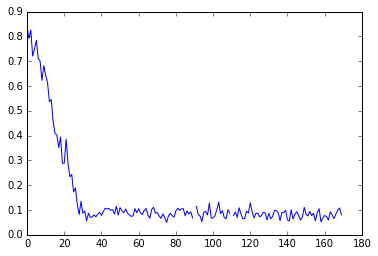

110
being: eta=2.4720519923774624e-06, obst_cnt=65.78255178207361, min_obst_r=3.154420094506941e-07, max_obst_r=3.318136774654004e-07
result_params:
[[  9.43069485e-01   8.29003542e-15]
 [  9.05746990e-01   4.37990529e-15]
 [  8.93049722e-01   2.87853382e-15]]
fitness:
0.0799014531658


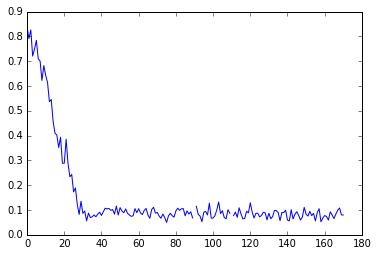

110
being: eta=2.4567498194781663e-06, obst_cnt=70.06288464586316, min_obst_r=4.310285619743733e-07, max_obst_r=3.324895958258007e-07
result_params:
[[  9.31827332e-01   7.99131022e-15]
 [  9.07450591e-01   3.99789454e-15]
 [  8.42395205e-01   3.10053214e-15]]
fitness:
0.101257001379


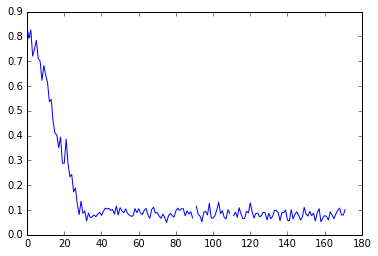

110
being: eta=2.4567498194781663e-06, obst_cnt=70.06288464586316, min_obst_r=4.310285619743733e-07, max_obst_r=3.324895958258007e-07
result_params:
[[  9.36305242e-01   7.94014261e-15]
 [  8.92945550e-01   4.49690189e-15]
 [  8.64329618e-01   3.03540528e-15]]
fitness:
0.0940869314035


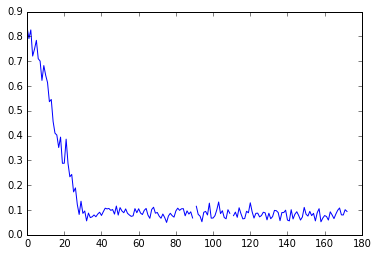

110
being: eta=2.454262826952854e-06, obst_cnt=66.99515882593255, min_obst_r=3.6988654039116954e-07, max_obst_r=3.135212586046347e-07
result_params:
[[  9.55337575e-01   7.69799972e-15]
 [  9.02245794e-01   4.26189793e-15]
 [  8.60905762e-01   3.20938288e-15]]
fitness:
0.115074818922


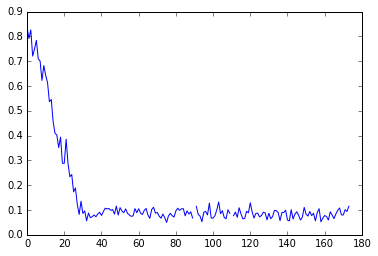

110
being: eta=2.405592445092673e-06, obst_cnt=69.57835008747345, min_obst_r=4.0337910009907106e-07, max_obst_r=3.616685371506438e-07
result_params:
[[  9.46100948e-01   7.72722165e-15]
 [  9.08068686e-01   4.12766892e-15]
 [  8.45176647e-01   3.13139169e-15]]
fitness:
0.115005723954


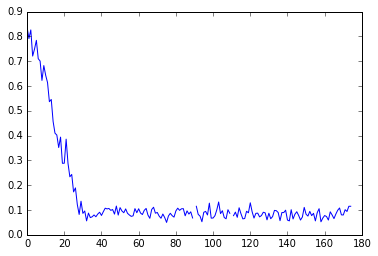

110
ERROR! prob=0.0 too low:
being: eta=2.409611485627814e-06, obst_cnt=56.15384408287944, min_obst_r=3.7313024694356844e-07, max_obst_r=3.2524691220985734e-07
result_params:
[[  9.04883517e-01   9.44441225e-15]
 [  9.22856659e-01   4.24482268e-15]
 [  8.89274825e-01   3.00143584e-15]]
fitness:
0.061095032218


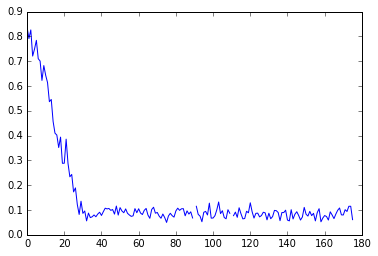

110
being: eta=2.4715448936490946e-06, obst_cnt=67.84839420863466, min_obst_r=3.733783011944919e-07, max_obst_r=3.2665366364909514e-07
result_params:
[[  9.33631945e-01   8.33000759e-15]
 [  8.98489487e-01   4.36255385e-15]
 [  8.60331392e-01   2.96509285e-15]]
fitness:
0.0827741206125


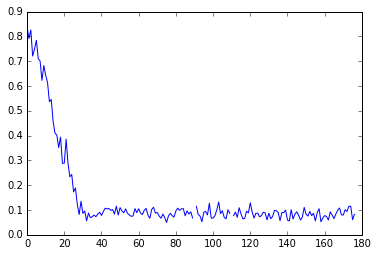

110
being: eta=2.4695539409674063e-06, obst_cnt=64.62297400918051, min_obst_r=3.91262718974716e-07, max_obst_r=3.790459240873847e-07
result_params:
[[  9.10847954e-01   8.59833480e-15]
 [  8.77295236e-01   4.49485120e-15]
 [  8.22456483e-01   3.17156955e-15]]
fitness:
0.0811317718988


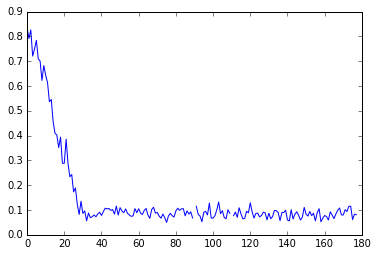

110
being: eta=2.5329048039124528e-06, obst_cnt=56.3492705347575, min_obst_r=3.8294017870879396e-07, max_obst_r=3.725194441901237e-07
result_params:
[[  9.62869734e-01   7.23789690e-15]
 [  9.19308922e-01   4.07902501e-15]
 [  8.82926313e-01   2.92298144e-15]]
fitness:
0.132318234042


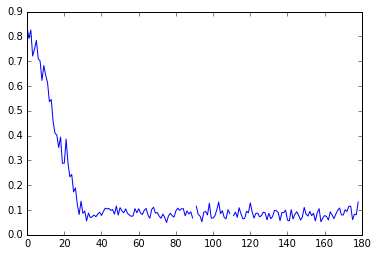

110


Process ForkPoolWorker-11135:
Process ForkPoolWorker-11133:
Process ForkPoolWorker-11132:
Process ForkPoolWorker-11134:
Process ForkPoolWorker-11131:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiproc

KeyboardInterrupt: 

In [143]:
def choose(array, indexes):
    return np.multiply(array.T, indexes).T 

def cross(being1, being2):
    indexes = np.random.choice([0, 1], size=being1.shape[0])
    return choose(being1, indexes) + choose(being2, 1 - indexes)

DELTAS = [[0, R**2], [0, 2 * pi], [0, H], None]

def mutate(being):
    next_being = being * (1 + np.random.randn(*being.shape) * 0.03)
    return next_being

def next_generation(generation):
    return [mutate(cross(being1, being2)) for being1 in generation for being2 in generation]

from multiprocessing import Pool

def sort_with_fitness(generation, fitness_function):
    print(len(generation))
    with Pool(5) as pool:
        fitnesses = pool.map(fitness_function, generation)
    sorted_zipped = sorted(zip(fitnesses, generation), key=itemgetter(0))
    sorted_beings = [being for (fitness, being) in sorted_zipped]
    sorted_fitnessess = [fitness for (fitness, being) in sorted_zipped]
    return sorted_beings, sorted_fitnessess

GEN_SIZE = 10
# generation = [np.array([ETA, OBST_CNT, O_MIN_R, O_MAX_R]) for i in range(GEN_SIZE)]
print(len(generation))

# best_fitnesses = []

while True:
    sorted_generation, sorted_fitnesses = sort_with_fitness(generation, calculate_fitness)
    best_fitness = calculate_fitness(sorted_generation[0], True)

    best_fitnesses.append(best_fitness)
    plt.plot(np.arange(len(best_fitnesses)), best_fitnesses)
    plt.show()
    
    generation = next_generation(sorted_generation[:GEN_SIZE]) + sorted_generation[:GEN_SIZE] 

result_params, fitness:


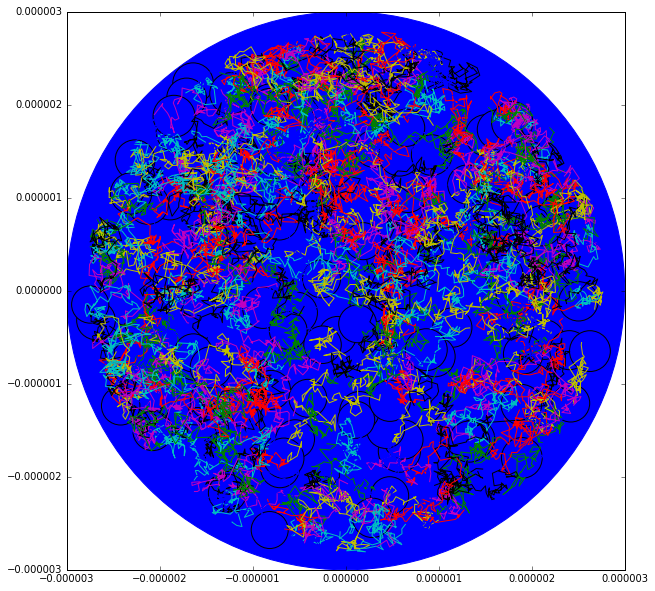

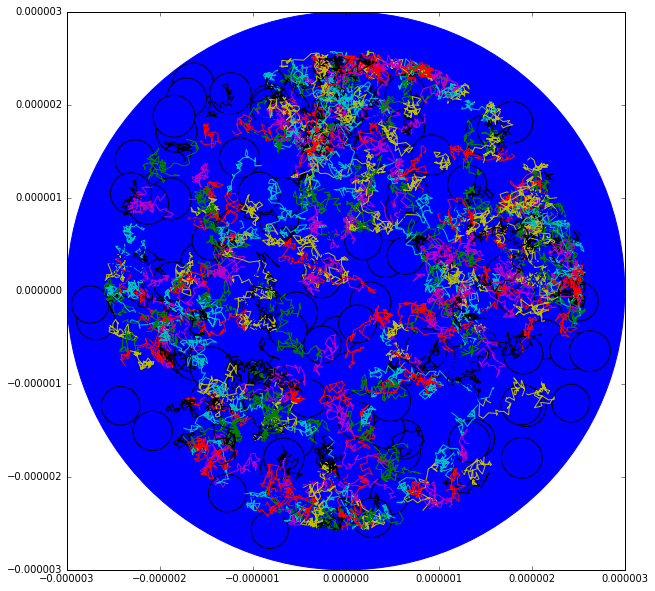

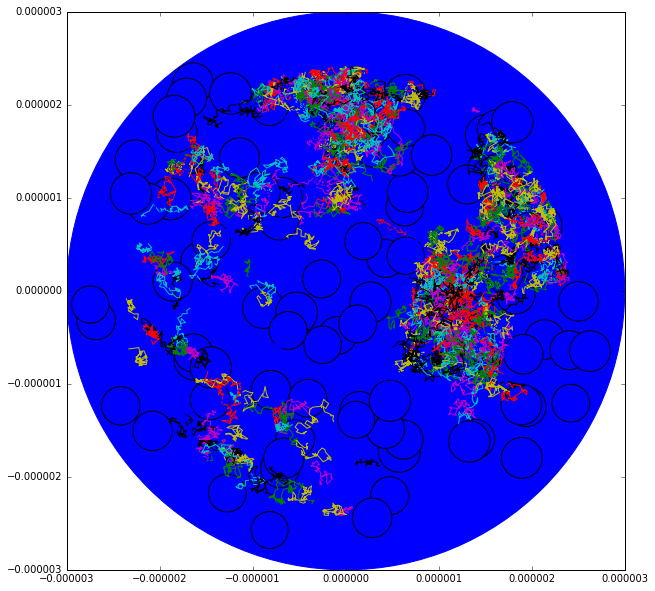

being: eta=2.390041077895209e-06, obst_cnt=81.13152512255667, min_obst_r=2.288326199782245e-07, max_obst_r=1.9845026286264843e-07
result_params:
[[  9.33271372e-01   8.92283380e-15]
 [  9.47315528e-01   4.13803662e-15]
 [  9.00591402e-01   3.03835550e-15]]
fitness:
0.0785382200527
0.0785382200527
targe vecotr:
[[  7.59902850e-01   9.36997804e-15]
 [  7.72527614e-01   4.17370658e-15]
 [  9.98571038e-01   2.32243200e-15]]


In [142]:
print('result_params, fitness:')
print(calculate_fitness(generation[0], True, True))
print('targe vecotr:')
print(target_vector)